In [1]:
!nvidia-smi

Sat Mar  2 17:06:51 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:2D:00.0  On |                  N/A |
|  0%   42C    P8    17W / 170W |    396MiB / 12288MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.getcwd()

'/home/bunny/projects/IConNet/notebooks'

In [4]:
os.chdir('..')

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [7]:
data_dir = '../data/crema_d/preprocessing/'

In [8]:
sr = 16000

data_x = np.load(f'{data_dir}crema_d.audio16k.npy', allow_pickle=True)
data_y = np.load(f'{data_dir}crema_d.label6.npy', allow_pickle=True)
# classnames = np.load(f'{data_dir}crema_d.classnames.npy', allow_pickle=True)
print(data_x.shape)
print(data_y.shape)
np.unique(data_y)

(7442,)
(7442,)


array(['ang', 'dis', 'fea', 'hap', 'neu', 'sad'], dtype=object)

In [9]:
labels = ['ang', 'neu', 'sad', 'hap']

def label_filter(label):
    return label[:3] in labels

def label_to_index(label):
    return labels.index(label[:3])
    
filtered_idx = [label_filter(idx) for idx in data_y]
data_x = data_x[filtered_idx]
data_y = [label_to_index(idx) for idx in data_y[filtered_idx]]
print(data_x.shape)

(4900,)


In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, 
    random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 3920
Test: 980


In [11]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [12]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.).permute(0, 2, 1)
    return batch

def collate_fn(batch, max_duration_in_second=3, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            waveform = np.array(waveform, dtype=float).squeeze()
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = waveform[offset: length-offset]
        tensors += [torch.tensor(waveform, dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label, dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [13]:
from IConNet.nn.model import M13

In [14]:
from omegaconf import OmegaConf as ocf

In [15]:
import traceback

In [16]:
model_config_path = 'config/model/m17.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M17', 'description': 'FirConv with fftconv + sinc', 'fe': {'n_block': 2, 'n_channel': [198, 30], 'kernel_size': [511, 127], 'stride': [2, 4], 'window_k': [5, 9], 'mel_resolution': 3, 'residual_connection_type': 'stack', 'pooling': 'mean', 'filter_type': 'sinc', 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}

In [17]:
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

M13(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm):

In [18]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [19]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch, test_loader=test_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [20]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                   | 0.0032679738562091504/10 [00:01<1:18:37, 471.93s/it]

Train Epoch: 1 [0/3920 (0%)]	Loss: 1.944082
Mem before-during-after: 1907712 3965312512 31229952


  1%|▉                                                                       | 0.1339869281045752/10 [00:16<21:42, 132.06s/it]

Train Epoch: 1 [640/3920 (16%)]	Loss: 1.320077
Mem before-during-after: 31229952 3978054656 32111616


  3%|█▉                                                                     | 0.26470588235294074/10 [00:31<20:24, 125.76s/it]

Train Epoch: 1 [1280/3920 (33%)]	Loss: 1.061665
Mem before-during-after: 32111616 3979723264 31354880


  4%|██▊                                                                     | 0.3954248366013063/10 [00:46<20:07, 125.72s/it]

Train Epoch: 1 [1920/3920 (49%)]	Loss: 0.786842
Mem before-during-after: 31374848 3979660800 31229952


  5%|███▊                                                                    | 0.5261437908496719/10 [01:00<19:51, 125.81s/it]

Train Epoch: 1 [2560/3920 (65%)]	Loss: 0.969187
Mem before-during-after: 32111616 3978842112 31230464


  7%|████▋                                                                   | 0.6568627450980374/10 [01:15<19:39, 126.21s/it]

Train Epoch: 1 [3200/3920 (82%)]	Loss: 1.416891
Mem before-during-after: 32111616 3979985408 31292416


  8%|█████▋                                                                   | 0.787581699346403/10 [01:29<19:13, 125.22s/it]

Train Epoch: 1 [3840/3920 (98%)]	Loss: 1.288038
Mem before-during-after: 31354880 3979660800 31229952


 10%|███████▍                                                                  | 0.999999999999997/10 [01:44<09:34, 63.88s/it]


Test Epoch: 1	Accuracy: 526/976 (54%)



 10%|███████▎                                                                 | 1.0032679738562063/10 [01:44<11:44, 78.31s/it]

Train Epoch: 2 [0/3920 (0%)]	Loss: 1.189530
Mem before-during-after: 31222784 3979145216 31229952


 11%|████████▏                                                               | 1.1339869281045718/10 [01:59<18:32, 125.45s/it]

Train Epoch: 2 [640/3920 (16%)]	Loss: 0.911812
Mem before-during-after: 31374848 3979598336 31229952


 13%|█████████                                                               | 1.2647058823529373/10 [02:13<18:13, 125.15s/it]

Train Epoch: 2 [1280/3920 (33%)]	Loss: 0.774557
Mem before-during-after: 31249920 3979743744 31375360


 14%|██████████▏                                                              | 1.395424836601303/10 [02:28<17:58, 125.34s/it]

Train Epoch: 2 [1920/3920 (49%)]	Loss: 0.938091
Mem before-during-after: 32111616 3979723264 31354880


 15%|██████████▉                                                             | 1.5261437908496684/10 [02:43<17:40, 125.17s/it]

Train Epoch: 2 [2560/3920 (65%)]	Loss: 0.759972
Mem before-during-after: 32111616 3980068352 31554560


 17%|████████████                                                             | 1.656862745098034/10 [02:57<17:19, 124.54s/it]

Train Epoch: 2 [3200/3920 (82%)]	Loss: 0.704199
Mem before-during-after: 31230464 3979723264 32111616


 18%|████████████▊                                                           | 1.7875816993463995/10 [03:12<17:11, 125.54s/it]

Train Epoch: 2 [3840/3920 (98%)]	Loss: 1.139870
Mem before-during-after: 31284224 3980534272 31284224


 20%|██████████████▌                                                          | 1.9999999999999936/10 [03:26<08:28, 63.51s/it]


Test Epoch: 2	Accuracy: 571/976 (58%)



 20%|██████████████▊                                                           | 2.003267973856203/10 [03:26<10:22, 77.90s/it]

Train Epoch: 3 [0/3920 (0%)]	Loss: 0.826476
Mem before-during-after: 31222784 3979270144 31229952


 21%|███████████████▎                                                        | 2.1339869281045685/10 [03:41<16:24, 125.14s/it]

Train Epoch: 3 [640/3920 (16%)]	Loss: 0.638847
Mem before-during-after: 32111616 3980047872 31354880


 23%|████████████████▌                                                        | 2.264705882352934/10 [03:56<16:15, 126.11s/it]

Train Epoch: 3 [1280/3920 (33%)]	Loss: 1.282801
Mem before-during-after: 31259648 3979682816 32111616


 24%|█████████████████▏                                                      | 2.3954248366012996/10 [04:10<15:58, 126.08s/it]

Train Epoch: 3 [1920/3920 (49%)]	Loss: 0.718094
Mem before-during-after: 32111616 3978842112 31230464


 25%|██████████████████▍                                                      | 2.526143790849665/10 [04:25<15:42, 126.13s/it]

Train Epoch: 3 [2560/3920 (65%)]	Loss: 0.708098
Mem before-during-after: 31284224 3978895872 32111616


 27%|███████████████████▏                                                    | 2.6568627450980307/10 [04:40<15:19, 125.19s/it]

Train Epoch: 3 [3200/3920 (82%)]	Loss: 1.038588
Mem before-during-after: 32111616 3978895872 31284224


 28%|████████████████████▎                                                    | 2.787581699346396/10 [04:54<15:06, 125.75s/it]

Train Epoch: 3 [3840/3920 (98%)]	Loss: 0.854693
Mem before-during-after: 31229952 3979723264 32111616


 30%|█████████████████████▉                                                   | 2.9999999999999902/10 [05:09<07:27, 63.93s/it]


Test Epoch: 3	Accuracy: 497/976 (51%)



 30%|█████████████████████▉                                                   | 3.0032679738561994/10 [05:09<09:07, 78.31s/it]

Train Epoch: 4 [0/3920 (0%)]	Loss: 1.032779
Mem before-during-after: 31222784 3979270144 31229952


 31%|██████████████████████▉                                                  | 3.133986928104565/10 [05:24<14:18, 124.96s/it]

Train Epoch: 4 [640/3920 (16%)]	Loss: 0.858176
Mem before-during-after: 31471616 3979966464 31229952


 33%|███████████████████████▌                                                | 3.2647058823529305/10 [05:38<14:12, 126.52s/it]

Train Epoch: 4 [1280/3920 (33%)]	Loss: 0.503713
Mem before-during-after: 31229952 3978787840 32111616


 34%|████████████████████████▊                                                | 3.395424836601296/10 [05:53<13:47, 125.33s/it]

Train Epoch: 4 [1920/3920 (49%)]	Loss: 1.151834
Mem before-during-after: 31229952 3979723264 32111616


 35%|█████████████████████████▍                                              | 3.5261437908496616/10 [06:07<13:21, 123.87s/it]

Train Epoch: 4 [2560/3920 (65%)]	Loss: 0.832642
Mem before-during-after: 31229952 3979723264 32111616


 37%|██████████████████████████▋                                              | 3.656862745098027/10 [06:22<13:13, 125.10s/it]

Train Epoch: 4 [3200/3920 (82%)]	Loss: 1.044929
Mem before-during-after: 31284224 3890180096 31229952


 38%|███████████████████████████▎                                            | 3.7875816993463927/10 [06:36<12:50, 124.06s/it]

Train Epoch: 4 [3840/3920 (98%)]	Loss: 0.965662
Mem before-during-after: 32236544 3814117376 31229952


 40%|█████████████████████████████▏                                           | 3.9999999999999867/10 [06:51<06:27, 64.57s/it]


Test Epoch: 4	Accuracy: 593/976 (61%)



 40%|█████████████████████████████▌                                            | 4.003267973856196/10 [06:51<07:51, 78.68s/it]

Train Epoch: 5 [0/3920 (0%)]	Loss: 0.946797
Mem before-during-after: 31222784 3979270144 31229952


 41%|██████████████████████████████▏                                          | 4.133986928104561/10 [07:06<12:11, 124.62s/it]

Train Epoch: 5 [640/3920 (16%)]	Loss: 1.395293
Mem before-during-after: 32111616 3980047872 31554560


 43%|███████████████████████████████▏                                         | 4.264705882352927/10 [07:20<11:55, 124.69s/it]

Train Epoch: 5 [1280/3920 (33%)]	Loss: 0.641942
Mem before-during-after: 31284224 3978895872 32111616


 44%|███████████████████████████████▋                                        | 4.3954248366012925/10 [07:35<11:48, 126.36s/it]

Train Epoch: 5 [1920/3920 (49%)]	Loss: 0.838816
Mem before-during-after: 32236544 3978966016 31292416


 45%|█████████████████████████████████                                        | 4.526143790849658/10 [07:49<11:19, 124.21s/it]

Train Epoch: 5 [2560/3920 (65%)]	Loss: 0.723230
Mem before-during-after: 31284224 3979777536 32111616


 47%|█████████████████████████████████▉                                       | 4.656862745098024/10 [08:04<11:29, 128.99s/it]

Train Epoch: 5 [3200/3920 (82%)]	Loss: 0.860315
Mem before-during-after: 32236544 3980047872 31679488


 48%|██████████████████████████████████▉                                      | 4.787581699346389/10 [08:18<10:46, 124.09s/it]

Train Epoch: 5 [3840/3920 (98%)]	Loss: 1.206854
Mem before-during-after: 31230464 3980534272 31284224


 50%|████████████████████████████████████▉                                     | 4.999999999999983/10 [08:32<05:24, 64.90s/it]


Test Epoch: 5	Accuracy: 548/976 (56%)



 50%|█████████████████████████████████████                                     | 5.003267973856192/10 [08:33<06:36, 79.45s/it]

Train Epoch: 6 [0/3920 (0%)]	Loss: 1.050449
Mem before-during-after: 31222784 3979270144 31229952


 51%|█████████████████████████████████████▍                                   | 5.133986928104558/10 [08:47<10:00, 123.47s/it]

Train Epoch: 6 [640/3920 (16%)]	Loss: 1.186118
Mem before-during-after: 31230464 3516361216 31229952


 53%|██████████████████████████████████████▍                                  | 5.264705882352923/10 [09:02<09:48, 124.18s/it]

Train Epoch: 6 [1280/3920 (33%)]	Loss: 1.098436
Mem before-during-after: 31292416 3979985408 31554560


 54%|███████████████████████████████████████▍                                 | 5.395424836601289/10 [09:16<09:33, 124.59s/it]

Train Epoch: 6 [1920/3920 (49%)]	Loss: 0.897283
Mem before-during-after: 32111616 3978841600 31229952


 55%|███████████████████████████████████████▊                                | 5.5261437908496545/10 [09:31<09:14, 123.90s/it]

Train Epoch: 6 [2560/3920 (65%)]	Loss: 0.965827
Mem before-during-after: 31284736 3980534272 31284224


 57%|█████████████████████████████████████████▊                                | 5.65686274509802/10 [09:45<09:00, 124.34s/it]

Train Epoch: 6 [3200/3920 (82%)]	Loss: 0.922330
Mem before-during-after: 31284224 3979777536 32111616


 58%|█████████████████████████████████████████▋                              | 5.7875816993463856/10 [10:00<08:38, 122.99s/it]

Train Epoch: 6 [3840/3920 (98%)]	Loss: 0.967107
Mem before-during-after: 31229952 3981695488 32111616


 60%|████████████████████████████████████████████▉                              | 5.99999999999998/10 [10:14<04:11, 62.96s/it]


Test Epoch: 6	Accuracy: 592/976 (60%)



 60%|████████████████████████████████████████████▍                             | 6.003267973856189/10 [10:14<05:03, 75.91s/it]

Train Epoch: 7 [0/3920 (0%)]	Loss: 1.004566
Mem before-during-after: 31222784 3731575296 31432192


 61%|████████████████████████████████████████████▊                            | 6.133986928104554/10 [10:29<07:58, 123.69s/it]

Train Epoch: 7 [640/3920 (16%)]	Loss: 0.521352
Mem before-during-after: 31284224 3772904960 31284736


 63%|██████████████████████████████████████████████▎                           | 6.26470588235292/10 [10:44<07:43, 124.04s/it]

Train Epoch: 7 [1280/3920 (33%)]	Loss: 1.035568
Mem before-during-after: 31229952 3979723264 32111616


 64%|██████████████████████████████████████████████▋                          | 6.395424836601285/10 [10:58<07:28, 124.46s/it]

Train Epoch: 7 [1920/3920 (49%)]	Loss: 0.655261
Mem before-during-after: 32111616 3978842112 31230464


 65%|███████████████████████████████████████████████▋                         | 6.526143790849651/10 [11:13<07:12, 124.50s/it]

Train Epoch: 7 [2560/3920 (65%)]	Loss: 1.077656
Mem before-during-after: 31292416 3979228672 31554560


 67%|███████████████████████████████████████████████▉                        | 6.6568627450980165/10 [11:27<06:56, 124.69s/it]

Train Epoch: 7 [3200/3920 (82%)]	Loss: 0.926198
Mem before-during-after: 31292416 3980372480 31679488


 68%|█████████████████████████████████████████████████▌                       | 6.787581699346382/10 [11:42<06:38, 124.15s/it]

Train Epoch: 7 [3840/3920 (98%)]	Loss: 0.677024
Mem before-during-after: 32111616 3978895872 31284224


 70%|███████████████████████████████████████████████████▊                      | 6.999999999999976/10 [11:56<03:10, 63.38s/it]


Test Epoch: 7	Accuracy: 590/976 (60%)



 70%|███████████████████████████████████████████████████▊                      | 7.003267973856185/10 [11:56<03:52, 77.60s/it]

Train Epoch: 8 [0/3920 (0%)]	Loss: 0.948052
Mem before-during-after: 31222784 3979270144 31229952


 71%|████████████████████████████████████████████████████                     | 7.133986928104551/10 [12:11<05:54, 123.56s/it]

Train Epoch: 8 [640/3920 (16%)]	Loss: 1.269170
Mem before-during-after: 31284224 3979777536 32236544


 73%|█████████████████████████████████████████████████████                    | 7.264705882352916/10 [12:25<05:47, 126.89s/it]

Train Epoch: 8 [1280/3920 (33%)]	Loss: 0.856456
Mem before-during-after: 31292416 3979652608 31284224


 74%|█████████████████████████████████████████████████████▉                   | 7.395424836601282/10 [12:40<05:26, 125.51s/it]

Train Epoch: 8 [1920/3920 (49%)]	Loss: 0.608073
Mem before-during-after: 32111616 3979660800 31292416


 75%|██████████████████████████████████████████████████████▉                  | 7.526143790849647/10 [12:55<05:13, 126.78s/it]

Train Epoch: 8 [2560/3920 (65%)]	Loss: 0.918857
Mem before-during-after: 31292416 3979723264 32236544


 77%|███████████████████████████████████████████████████████▉                 | 7.656862745098013/10 [13:09<04:52, 124.88s/it]

Train Epoch: 8 [3200/3920 (82%)]	Loss: 1.089233
Mem before-during-after: 31292416 3979598336 32111616


 78%|████████████████████████████████████████████████████████                | 7.7875816993463784/10 [13:24<04:37, 125.26s/it]

Train Epoch: 8 [3840/3920 (98%)]	Loss: 1.030079
Mem before-during-after: 31229952 3978842624 32111616


 80%|██████████████████████████████████████████████████████████▍              | 7.9999999999999725/10 [13:38<02:07, 63.75s/it]


Test Epoch: 8	Accuracy: 598/976 (61%)



 80%|███████████████████████████████████████████████████████████▏              | 8.003267973856182/10 [13:39<02:35, 78.06s/it]

Train Epoch: 9 [0/3920 (0%)]	Loss: 0.764631
Mem before-during-after: 31222784 3979270144 31229952


 81%|███████████████████████████████████████████████████████████▍             | 8.133986928104548/10 [13:53<03:52, 124.39s/it]

Train Epoch: 9 [640/3920 (16%)]	Loss: 0.682552
Mem before-during-after: 31283712 3978895360 32111616


 83%|████████████████████████████████████████████████████████████▎            | 8.264705882352914/10 [14:08<03:36, 124.80s/it]

Train Epoch: 9 [1280/3920 (33%)]	Loss: 0.938182
Mem before-during-after: 31284224 3979777536 32111616


 84%|██████████████████████████████████████████████████████████████▏           | 8.39542483660128/10 [14:22<03:21, 125.65s/it]

Train Epoch: 9 [1920/3920 (49%)]	Loss: 0.940438
Mem before-during-after: 31292416 3979553280 31554560


 85%|██████████████████████████████████████████████████████████████▏          | 8.526143790849645/10 [14:37<03:07, 127.38s/it]

Train Epoch: 9 [2560/3920 (65%)]	Loss: 0.684533
Mem before-during-after: 31229952 3940666880 31259648


 87%|████████████████████████████████████████████████████████████████          | 8.65686274509801/10 [14:52<02:47, 125.06s/it]

Train Epoch: 9 [3200/3920 (82%)]	Loss: 1.053079
Mem before-during-after: 31354880 3980480000 32111616


 88%|████████████████████████████████████████████████████████████████▏        | 8.787581699346376/10 [15:07<02:31, 125.23s/it]

Train Epoch: 9 [3840/3920 (98%)]	Loss: 0.873290
Mem before-during-after: 32111616 3978895872 31284224


 90%|███████████████████████████████████████████████████████████████████▍       | 8.99999999999997/10 [15:21<01:03, 63.72s/it]


Test Epoch: 9	Accuracy: 597/976 (61%)



 90%|██████████████████████████████████████████████████████████████████▌       | 9.003267973856179/10 [15:21<01:23, 83.55s/it]

Train Epoch: 10 [0/3920 (0%)]	Loss: 0.483581
Mem before-during-after: 31222784 3896880640 31295488


 91%|██████████████████████████████████████████████████████████████████▋      | 9.133986928104544/10 [15:36<01:46, 123.42s/it]

Train Epoch: 10 [640/3920 (16%)]	Loss: 0.823561
Mem before-during-after: 31284224 3598585856 31229952


 93%|████████████████████████████████████████████████████████████████████▌     | 9.26470588235291/10 [15:51<01:31, 124.30s/it]

Train Epoch: 10 [1280/3920 (33%)]	Loss: 0.822188
Mem before-during-after: 32236544 3979291136 31229952


 94%|████████████████████████████████████████████████████████████████████▌    | 9.395424836601276/10 [16:05<01:15, 124.92s/it]

Train Epoch: 10 [1920/3920 (49%)]	Loss: 0.662153
Mem before-during-after: 31229952 3979723264 32111616


 95%|█████████████████████████████████████████████████████████████████████▌   | 9.526143790849641/10 [16:20<00:59, 124.54s/it]

Train Epoch: 10 [2560/3920 (65%)]	Loss: 0.869919
Mem before-during-after: 31230464 3980208128 31229952


 97%|██████████████████████████████████████████████████████████████████████▍  | 9.656862745098007/10 [16:34<00:43, 127.07s/it]

Train Epoch: 10 [3200/3920 (82%)]	Loss: 0.770159
Mem before-during-after: 32111616 3978841600 31229952


 98%|███████████████████████████████████████████████████████████████████████▍ | 9.787581699346372/10 [16:49<00:26, 125.15s/it]

Train Epoch: 10 [3840/3920 (98%)]	Loss: 0.800621
Mem before-during-after: 31292416 3979163136 31554560


100%|████████████████████████████████████████████████████████████████████████▉| 9.999999999999966/10 [17:03<00:00, 102.35s/it]


Test Epoch: 10	Accuracy: 587/976 (60%)



In [21]:
model_path = '../models_cremad4/cremad_label4_m17_10epochs.pt' 
torch.save(model.state_dict(), model_path)

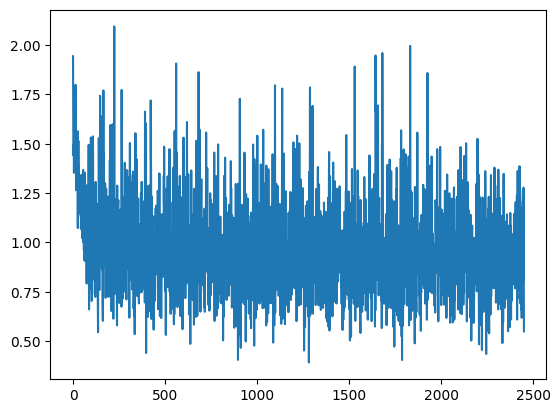

In [22]:
plt.plot(train_losses)

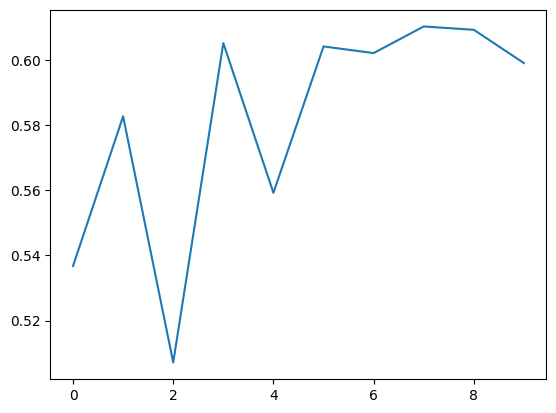

In [23]:
plt.plot(test_accuracy)

In [24]:
layer = model.fe_blocks.blocks[0].block.layer
named_params = [p for p in layer.named_parameters()]
named_params

[('lowcut_bands',
  Parameter containing:
  tensor([[ 0.0000],
          [-0.0722],
          [ 0.0717],
          [ 0.0388],
          [ 0.0715],
          [ 0.1898],
          [-0.1410],
          [ 0.0772],
          [-0.0536],
          [-0.1258],
          [ 0.0394],
          [-0.0473],
          [ 0.0477],
          [ 0.0357],
          [ 0.1225],
          [-0.1169],
          [ 0.0397],
          [ 0.0328],
          [-0.1914],
          [-0.0307],
          [-0.1249],
          [ 0.1010],
          [-0.0065],
          [-0.1242],
          [ 0.1197],
          [-0.1417],
          [-0.0212],
          [-0.0331],
          [ 0.0473],
          [-0.0190],
          [-0.1024],
          [ 0.0391],
          [-0.0039],
          [ 0.0140],
          [ 0.2002],
          [-0.0395],
          [ 0.0982],
          [ 0.2028],
          [ 0.1603],
          [ 0.1429],
          [ 0.1466],
          [ 0.3868],
          [ 0.1314],
          [-0.1937],
          [ 0.2647],
          [ 0

In [25]:
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [ 5.4786e-03],
        [-7.3075e-03],
        [ 3.8334e-02],
        [-4.3602e-03],
        [ 1.6118e-02],
        [-1.9694e-02],
        [-5.5122e-03],
        [ 2.9939e-03],
        [ 1.9695e-02],
        [ 3.4499e-02],
        [ 9.4359e-04],
        [ 3.6457e-03],
        [-8.7681e-03],
        [ 3.5279e-03],
        [-1.3608e-02],
        [ 3.8747e-03],
        [ 1.9030e-02],
        [ 6.9865e-03],
        [ 2.3177e-02],
        [ 1.6627e-02],
        [ 4.2587e-03],
        [-3.2860e-02],
        [ 2.5551e-02],
        [-2.4995e-03],
        [-1.4797e-02],
        [ 8.0001e-03],
        [ 2.1766e-03],
        [ 6.4044e-03],
        [ 1.8310e-02],
        [ 1.0445e-02],
        [-1.1597e-02],
        [ 6.7128e-04],
        [ 8.4193e-03],
        [ 1.2780e-02],
        [-3.6237e-03],
        [ 2.3811e-04],
        [ 2.7774e-02],
        [ 1.5112e-02],
        [ 1.3569e-02],
        [ 3.0125e-04],
        [-5.9331e-03],
        [ 5.5682e-02],
        [ 4

[None, None, None]

(array([ 3.,  2.,  4.,  5.,  3.,  2.,  4., 12.,  4.,  9.,  4., 13.,  6.,
         7., 10., 13.,  7.,  8.,  7., 13.,  7.,  4.,  3.,  1.,  5.,  6.,
         3.,  3.,  6., 12.,  0.,  4.,  0.,  2.,  0.,  3.,  1.,  0.,  0.,
         2.]),
 array([-0.19372447, -0.17326784, -0.15281121, -0.1323546 , -0.11189797,
        -0.09144135, -0.07098472, -0.0505281 , -0.03007147, -0.00961485,
         0.01084178,  0.0312984 ,  0.05175503,  0.07221165,  0.09266827,
         0.1131249 ,  0.13358152,  0.15403815,  0.17449477,  0.1949514 ,
         0.21540803,  0.23586464,  0.25632128,  0.27677789,  0.29723451,
         0.31769115,  0.33814776,  0.3586044 ,  0.37906101,  0.39951763,
         0.41997427,  0.44043088,  0.46088752,  0.48134413,  0.50180078,
         0.52225739,  0.542714  ,  0.56317061,  0.58362728,  0.6040839 ,
         0.62454051]),
 <BarContainer object of 40 artists>)

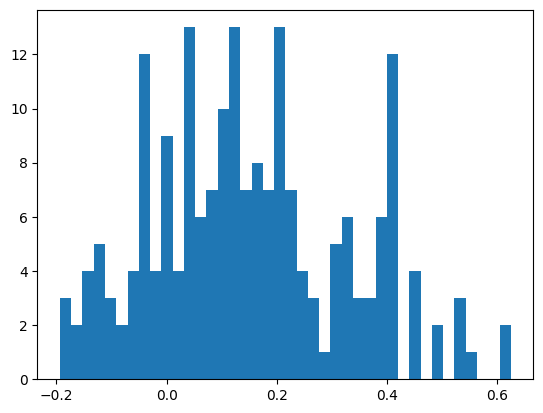

In [26]:
lowcut_bands = named_params[0][1].detach().cpu().numpy()
plt.hist(lowcut_bands.flatten(), bins=40)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         1.,  0.,  2.,  0.,  2.,  0.,  2.,  6.,  9., 10.,  4., 13., 21.,
        17., 37., 23., 14., 11.,  7.,  5.,  5.,  1.,  2.,  1.,  0.,  1.,
         2.]),
 array([-0.13944475, -0.13431369, -0.12918261, -0.12405153, -0.11892046,
        -0.11378939, -0.10865831, -0.10352724, -0.09839617, -0.09326509,
        -0.08813402, -0.08300295, -0.07787188, -0.07274081, -0.06760973,
        -0.06247866, -0.05734759, -0.05221651, -0.04708544, -0.04195437,
        -0.0368233 , -0.03169222, -0.02656115, -0.02143008, -0.016299  ,
        -0.01116793, -0.00603686, -0.00090578,  0.00422529,  0.00935636,
         0.01448743,  0.01961851,  0.02474958,  0.02988065,  0.03501173,
         0.0401428 ,  0.04527387,  0.05040494,  0.05553602,  0.06066709,
         0.06579816]),
 <BarContainer object of 40 artists>)

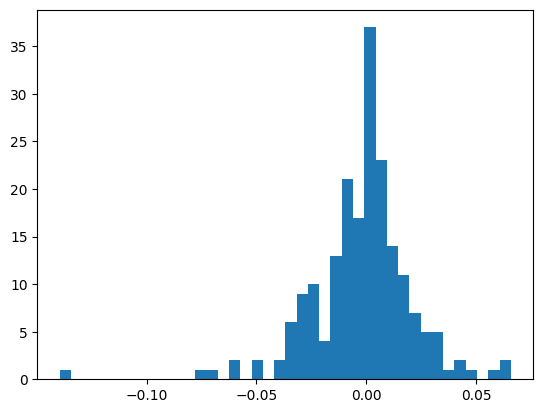

In [27]:
lowcut_bands_grad = named_params[0][1].grad.detach().cpu().numpy()
plt.hist(lowcut_bands_grad.flatten(), bins=40)

(array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  1.,  2.,  5.,
         7.,  8.,  3., 10.,  5.,  5.,  1.,  4.,  5., 14.,  8., 15., 17.,
        15., 14.,  7., 13.,  6.,  6.,  6.,  5.,  2.,  0.,  1.,  2.,  1.,
         2.]),
 array([-0.2329915 , -0.22131497, -0.20963842, -0.19796188, -0.18628535,
        -0.17460881, -0.16293226, -0.15125573, -0.13957919, -0.12790266,
        -0.11622611, -0.10454957, -0.09287303, -0.08119649, -0.06951995,
        -0.05784342, -0.04616687, -0.03449034, -0.0228138 , -0.01113726,
         0.00053928,  0.01221582,  0.02389236,  0.0355689 ,  0.04724544,
         0.05892198,  0.07059851,  0.08227506,  0.09395159,  0.10562813,
         0.11730467,  0.12898122,  0.14065775,  0.15233429,  0.16401082,
         0.17568737,  0.18736391,  0.19904044,  0.21071698,  0.22239353,
         0.23407006]),
 <BarContainer object of 40 artists>)

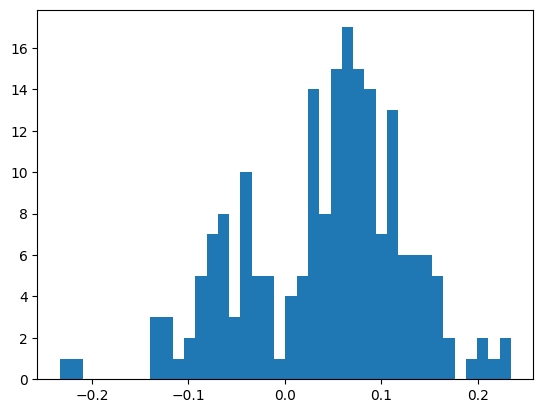

In [28]:
bandwidths = named_params[1][1].detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

(array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  1.,  2.,  5.,
         7.,  8.,  3., 10.,  5.,  5.,  1.,  4.,  5., 14.,  8., 15., 17.,
        15., 14.,  7., 13.,  6.,  6.,  6.,  5.,  2.,  0.,  1.,  2.,  1.,
         2.]),
 array([-0.2329915 , -0.22131497, -0.20963842, -0.19796188, -0.18628535,
        -0.17460881, -0.16293226, -0.15125573, -0.13957919, -0.12790266,
        -0.11622611, -0.10454957, -0.09287303, -0.08119649, -0.06951995,
        -0.05784342, -0.04616687, -0.03449034, -0.0228138 , -0.01113726,
         0.00053928,  0.01221582,  0.02389236,  0.0355689 ,  0.04724544,
         0.05892198,  0.07059851,  0.08227506,  0.09395159,  0.10562813,
         0.11730467,  0.12898122,  0.14065775,  0.15233429,  0.16401082,
         0.17568737,  0.18736391,  0.19904044,  0.21071698,  0.22239353,
         0.23407006]),
 <BarContainer object of 40 artists>)

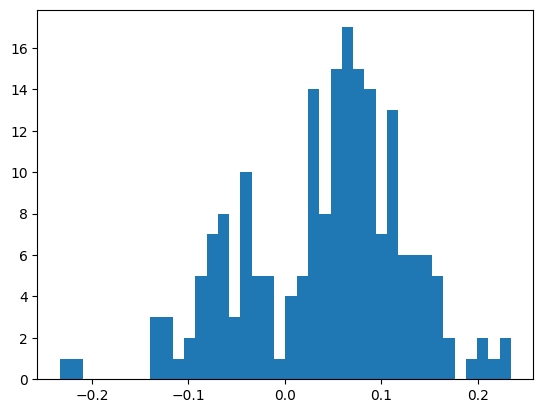

In [29]:
bandwidths_grad = named_params[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

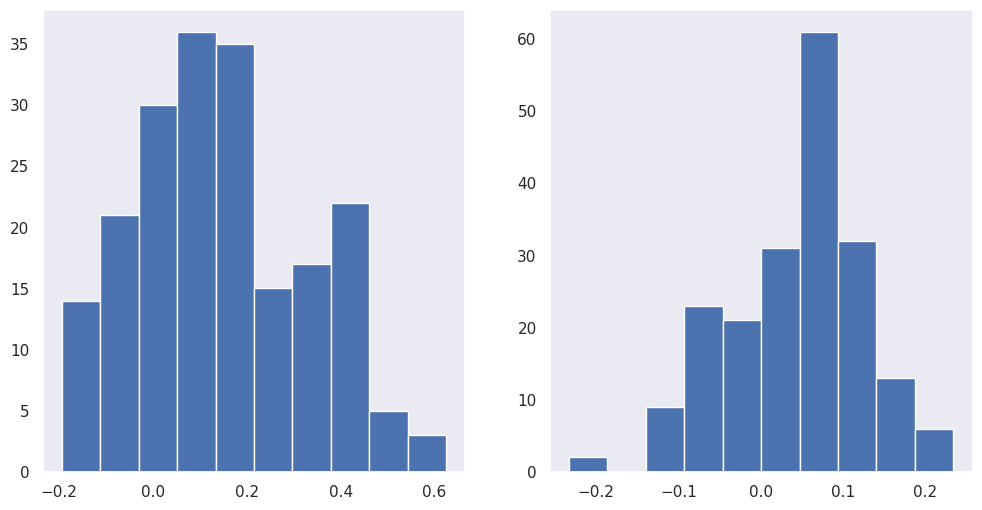

In [31]:
from IConNet.visualizer import visualize_model
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

Time domain: Filters' shapes vary by frequency bins


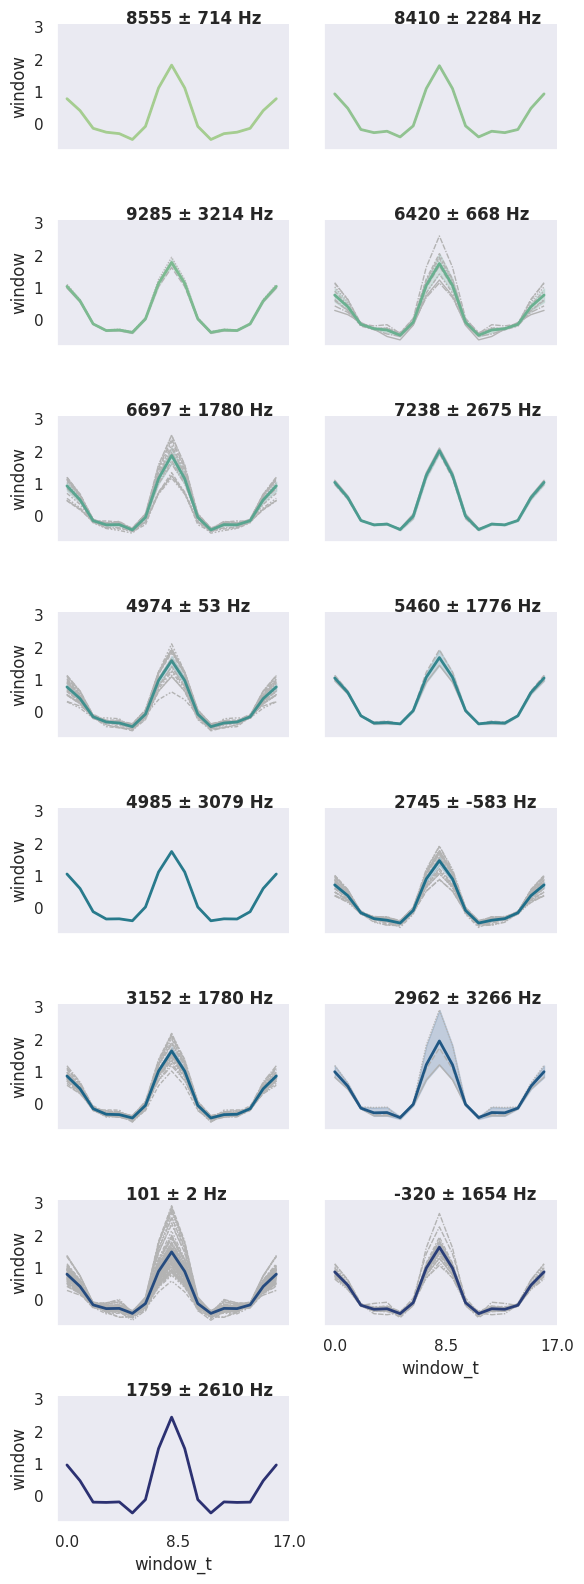

In [32]:
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


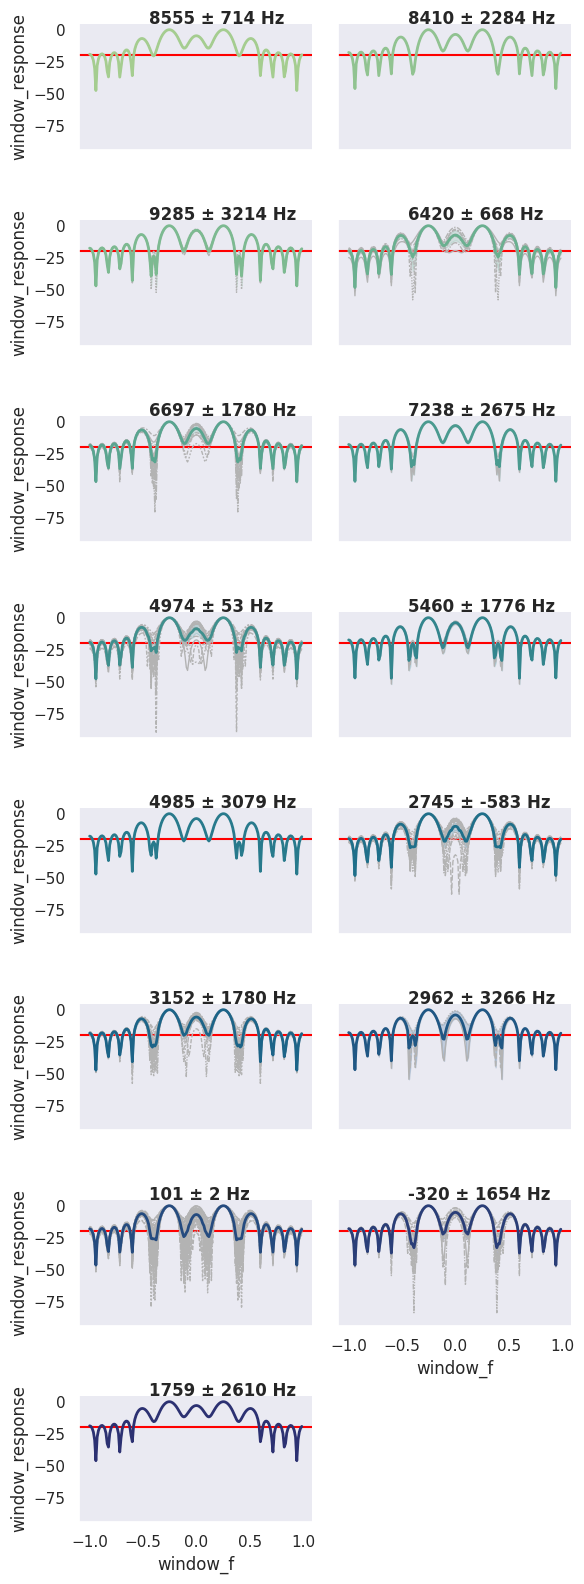

In [33]:
filtviz.visualize_filters(filter_domain='freq')

(array([ 3.,  2.,  4.,  5.,  3.,  2.,  4., 12.,  4.,  9.,  4., 13.,  6.,
         7., 10., 13.,  7.,  8.,  7., 13.,  7.,  4.,  3.,  1.,  5.,  6.,
         3.,  3.,  6., 12.,  0.,  4.,  0.,  2.,  0.,  3.,  1.,  0.,  0.,
         2.]),
 array([-0.19372447, -0.17326784, -0.15281121, -0.1323546 , -0.11189797,
        -0.09144135, -0.07098472, -0.0505281 , -0.03007147, -0.00961485,
         0.01084178,  0.0312984 ,  0.05175503,  0.07221165,  0.09266827,
         0.1131249 ,  0.13358152,  0.15403815,  0.17449477,  0.1949514 ,
         0.21540803,  0.23586464,  0.25632128,  0.27677789,  0.29723451,
         0.31769115,  0.33814776,  0.3586044 ,  0.37906101,  0.39951763,
         0.41997427,  0.44043088,  0.46088752,  0.48134413,  0.50180078,
         0.52225739,  0.542714  ,  0.56317061,  0.58362728,  0.6040839 ,
         0.62454051]),
 <BarContainer object of 40 artists>)

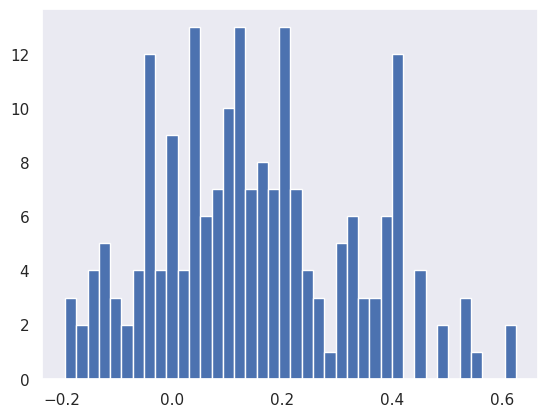

In [34]:
lowcut_bands = named_params[0][1].detach().cpu().numpy()
plt.hist(lowcut_bands.flatten(), bins=40)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         1.,  0.,  2.,  0.,  2.,  0.,  2.,  6.,  9., 10.,  4., 13., 21.,
        17., 37., 23., 14., 11.,  7.,  5.,  5.,  1.,  2.,  1.,  0.,  1.,
         2.]),
 array([-0.13944475, -0.13431369, -0.12918261, -0.12405153, -0.11892046,
        -0.11378939, -0.10865831, -0.10352724, -0.09839617, -0.09326509,
        -0.08813402, -0.08300295, -0.07787188, -0.07274081, -0.06760973,
        -0.06247866, -0.05734759, -0.05221651, -0.04708544, -0.04195437,
        -0.0368233 , -0.03169222, -0.02656115, -0.02143008, -0.016299  ,
        -0.01116793, -0.00603686, -0.00090578,  0.00422529,  0.00935636,
         0.01448743,  0.01961851,  0.02474958,  0.02988065,  0.03501173,
         0.0401428 ,  0.04527387,  0.05040494,  0.05553602,  0.06066709,
         0.06579816]),
 <BarContainer object of 40 artists>)

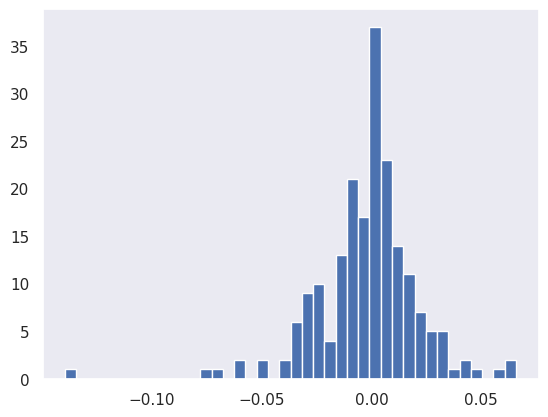

In [35]:
lowcut_bands_grad = named_params[0][1].grad.detach().cpu().numpy()
plt.hist(lowcut_bands_grad.flatten(), bins=40)

(array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  1.,  2.,  5.,
         7.,  8.,  3., 10.,  5.,  5.,  1.,  4.,  5., 14.,  8., 15., 17.,
        15., 14.,  7., 13.,  6.,  6.,  6.,  5.,  2.,  0.,  1.,  2.,  1.,
         2.]),
 array([-0.2329915 , -0.22131497, -0.20963842, -0.19796188, -0.18628535,
        -0.17460881, -0.16293226, -0.15125573, -0.13957919, -0.12790266,
        -0.11622611, -0.10454957, -0.09287303, -0.08119649, -0.06951995,
        -0.05784342, -0.04616687, -0.03449034, -0.0228138 , -0.01113726,
         0.00053928,  0.01221582,  0.02389236,  0.0355689 ,  0.04724544,
         0.05892198,  0.07059851,  0.08227506,  0.09395159,  0.10562813,
         0.11730467,  0.12898122,  0.14065775,  0.15233429,  0.16401082,
         0.17568737,  0.18736391,  0.19904044,  0.21071698,  0.22239353,
         0.23407006]),
 <BarContainer object of 40 artists>)

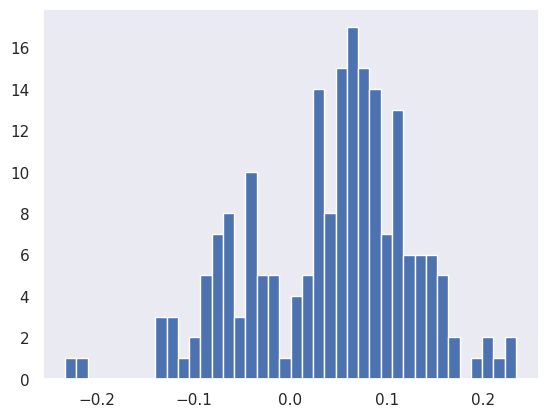

In [36]:
bandwidths = named_params[1][1].detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

(array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  1.,  2.,  5.,
         7.,  8.,  3., 10.,  5.,  5.,  1.,  4.,  5., 14.,  8., 15., 17.,
        15., 14.,  7., 13.,  6.,  6.,  6.,  5.,  2.,  0.,  1.,  2.,  1.,
         2.]),
 array([-0.2329915 , -0.22131497, -0.20963842, -0.19796188, -0.18628535,
        -0.17460881, -0.16293226, -0.15125573, -0.13957919, -0.12790266,
        -0.11622611, -0.10454957, -0.09287303, -0.08119649, -0.06951995,
        -0.05784342, -0.04616687, -0.03449034, -0.0228138 , -0.01113726,
         0.00053928,  0.01221582,  0.02389236,  0.0355689 ,  0.04724544,
         0.05892198,  0.07059851,  0.08227506,  0.09395159,  0.10562813,
         0.11730467,  0.12898122,  0.14065775,  0.15233429,  0.16401082,
         0.17568737,  0.18736391,  0.19904044,  0.21071698,  0.22239353,
         0.23407006]),
 <BarContainer object of 40 artists>)

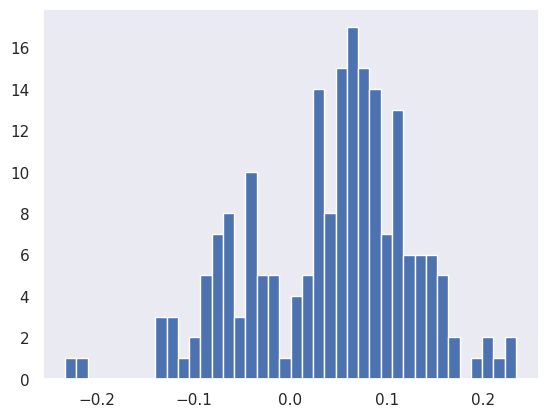

In [37]:
bandwidths_grad = named_params[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

In [39]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [40]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 587/976 (0.6014)
{'acc_detail': tensor([0.5692, 0.3917, 0.8268, 0.5873], device='cuda:0'),
 'acc_unweighted': tensor(0.5937, device='cuda:0'),
 'acc_weighted': tensor(0.6014, device='cuda:0'),
 'f1s_detail': tensor([0.6621, 0.4474, 0.7254, 0.5305], device='cuda:0'),
 'f1s_unweighted': tensor(0.5913, device='cuda:0'),
 'f1s_weighted': tensor(0.5968, device='cuda:0'),
 'precision_detail': tensor([0.7912, 0.5215, 0.6462, 0.4837], device='cuda:0'),
 'recall_detail': tensor([0.5692, 0.3917, 0.8268, 0.5873], device='cuda:0'),
 'rocauc': tensor(0.8546, device='cuda:0'),
 'rocauc_detail': tensor([0.9165, 0.8318, 0.9172, 0.7531], device='cuda:0'),
 'uar': tensor(0.5937, device='cuda:0'),
 'wap': tensor(0.6141, device='cuda:0')}


tensor([[144,   7,   3,  99],
        [  0,  85,  86,  46],
        [  1,  30, 210,  13],
        [ 37,  41,  26, 148]], device='cuda:0')

In [41]:
n_epoch = 10
n_epoch2 = 50
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_cremad4/cremad_label4_m17_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                   | 0.0032679738562091504/50 [00:00<2:05:19, 150.39s/it]

Train Epoch: 11 [0/3920 (0%)]	Loss: 0.894796
Mem before-during-after: 27702272 3975749632 31319040


  0%|▏                                                                     | 0.1339869281045752/50 [00:16<1:54:53, 138.24s/it]

Train Epoch: 11 [640/3920 (16%)]	Loss: 0.708406
Mem before-during-after: 31381504 3979865600 31319552


  1%|▎                                                                    | 0.26470588235294074/50 [00:32<1:57:13, 141.42s/it]

Train Epoch: 11 [1280/3920 (33%)]	Loss: 0.865074
Mem before-during-after: 32200704 3979812352 32200704


  1%|▌                                                                     | 0.3954248366013063/50 [00:48<1:52:10, 135.68s/it]

Train Epoch: 11 [1920/3920 (49%)]	Loss: 0.709626
Mem before-during-after: 31381504 3978993152 32325632


  1%|▋                                                                     | 0.5261437908496719/50 [01:04<1:51:02, 134.66s/it]

Train Epoch: 11 [2560/3920 (65%)]	Loss: 0.847939
Mem before-during-after: 31373312 3978984960 32200704


  1%|▉                                                                     | 0.6568627450980374/50 [01:20<1:50:20, 134.17s/it]

Train Epoch: 11 [3200/3920 (82%)]	Loss: 0.832062
Mem before-during-after: 31319040 3979812352 32200704


  2%|█                                                                      | 0.787581699346403/50 [01:36<1:53:35, 138.48s/it]

Train Epoch: 11 [3840/3920 (98%)]	Loss: 0.831654
Mem before-during-after: 31319040 3979687424 32200704


  2%|█▍                                                                      | 0.999999999999997/50 [01:53<1:02:38, 76.71s/it]


Test Epoch: 11	Accuracy: 598/976 (61%)

saved model: ../models_cremad4/cremad_label4_m17_best_11epoch.pt


  2%|█▍                                                                     | 1.0032679738562063/50 [01:53<1:13:55, 90.53s/it]

Train Epoch: 12 [0/3920 (0%)]	Loss: 0.361943
Mem before-during-after: 31311872 3979296768 31381504


  2%|█▌                                                                    | 1.1339869281045718/50 [02:09<1:49:55, 134.97s/it]

Train Epoch: 12 [640/3920 (16%)]	Loss: 0.820661
Mem before-during-after: 31319040 3979812352 31319040


  3%|█▊                                                                    | 1.2647058823529373/50 [02:25<1:51:37, 137.44s/it]

Train Epoch: 12 [1280/3920 (33%)]	Loss: 0.633084
Mem before-during-after: 32200704 3978984448 31372800


  3%|█▉                                                                     | 1.395424836601303/50 [02:41<1:52:00, 138.26s/it]

Train Epoch: 12 [1920/3920 (49%)]	Loss: 1.124664
Mem before-during-after: 32200704 3978931200 31319552


  3%|██▏                                                                   | 1.5261437908496684/50 [02:57<1:49:07, 135.07s/it]

Train Epoch: 12 [2560/3920 (65%)]	Loss: 1.027396
Mem before-during-after: 32200704 3978930688 31319040


  3%|██▎                                                                    | 1.656862745098034/50 [03:13<1:49:45, 136.22s/it]

Train Epoch: 12 [3200/3920 (82%)]	Loss: 1.025486
Mem before-during-after: 31381504 3979540992 31319552


  4%|██▌                                                                   | 1.7875816993463995/50 [03:29<1:49:14, 135.95s/it]

Train Epoch: 12 [3840/3920 (98%)]	Loss: 0.987716
Mem before-during-after: 32200704 3978930688 31319040


  4%|██▉                                                                      | 1.9999999999999936/50 [03:46<59:51, 74.82s/it]


Test Epoch: 12	Accuracy: 608/976 (62%)

saved model: ../models_cremad4/cremad_label4_m17_best_12epoch.pt


  4%|██▉                                                                     | 2.003267973856203/50 [03:46<1:11:44, 89.67s/it]

Train Epoch: 13 [0/3920 (0%)]	Loss: 0.872082
Mem before-during-after: 31311872 3979296768 31381504


  4%|██▉                                                                   | 2.1339869281045685/50 [04:02<1:49:19, 137.04s/it]

Train Epoch: 13 [640/3920 (16%)]	Loss: 1.051639
Mem before-during-after: 31381504 3980629504 31409152


  5%|███▏                                                                   | 2.264705882352934/50 [04:18<1:48:30, 136.39s/it]

Train Epoch: 13 [1280/3920 (33%)]	Loss: 0.942591
Mem before-during-after: 32200704 3978985472 31373824


  5%|███▎                                                                  | 2.3954248366012996/50 [04:34<1:47:33, 135.57s/it]

Train Epoch: 13 [1920/3920 (49%)]	Loss: 0.943639
Mem before-during-after: 32200704 3978930688 31319040


  5%|███▌                                                                   | 2.526143790849665/50 [04:50<1:46:41, 134.85s/it]

Train Epoch: 13 [2560/3920 (65%)]	Loss: 0.916986
Mem before-during-after: 31373824 3689393152 31319040


  5%|███▋                                                                  | 2.6568627450980307/50 [05:06<1:47:25, 136.15s/it]

Train Epoch: 13 [3200/3920 (82%)]	Loss: 0.668528
Mem before-during-after: 31319040 3979812352 31319040


  6%|███▉                                                                   | 2.787581699346396/50 [05:22<1:48:30, 137.89s/it]

Train Epoch: 13 [3840/3920 (98%)]	Loss: 0.524492
Mem before-during-after: 32325632 3979380224 31319040


  6%|████▍                                                                    | 2.9999999999999902/50 [05:39<59:13, 75.61s/it]


Test Epoch: 13	Accuracy: 603/976 (62%)



  6%|████▎                                                                  | 3.0032679738561994/50 [05:40<1:10:18, 89.77s/it]

Train Epoch: 14 [0/3920 (0%)]	Loss: 0.680939
Mem before-during-after: 31311872 3979296768 31381504


  6%|████▍                                                                  | 3.133986928104565/50 [05:55<1:46:04, 135.80s/it]

Train Epoch: 14 [640/3920 (16%)]	Loss: 0.965219
Mem before-during-after: 31373824 3980623360 31373312


  7%|████▌                                                                 | 3.2647058823529305/50 [06:11<1:44:55, 134.71s/it]

Train Epoch: 14 [1280/3920 (33%)]	Loss: 0.837472
Mem before-during-after: 32200704 3978930688 31319040


  7%|████▊                                                                  | 3.395424836601296/50 [06:27<1:43:52, 133.72s/it]

Train Epoch: 14 [1920/3920 (49%)]	Loss: 0.601912
Mem before-during-after: 32325632 3921058304 31319040


  7%|████▉                                                                 | 3.5261437908496616/50 [06:43<1:44:25, 134.82s/it]

Train Epoch: 14 [2560/3920 (65%)]	Loss: 0.504218
Mem before-during-after: 31436288 3979812352 31443968


  7%|█████▏                                                                 | 3.656862745098027/50 [06:59<1:44:09, 134.86s/it]

Train Epoch: 14 [3200/3920 (82%)]	Loss: 1.245772
Mem before-during-after: 32200704 3979812352 32325632


  8%|█████▎                                                                | 3.7875816993463927/50 [07:15<1:43:46, 134.73s/it]

Train Epoch: 14 [3840/3920 (98%)]	Loss: 0.876167
Mem before-during-after: 31319040 3979812352 32200704


  8%|█████▊                                                                   | 3.9999999999999867/50 [07:31<56:45, 74.02s/it]


Test Epoch: 14	Accuracy: 614/976 (63%)

saved model: ../models_cremad4/cremad_label4_m17_best_14epoch.pt


  8%|█████▊                                                                  | 4.003267973856196/50 [07:31<1:08:30, 89.36s/it]

Train Epoch: 15 [0/3920 (0%)]	Loss: 0.684012
Mem before-during-after: 31311872 3979359232 31319040


  8%|█████▊                                                                 | 4.133986928104561/50 [07:48<1:45:46, 138.37s/it]

Train Epoch: 15 [640/3920 (16%)]	Loss: 0.786019
Mem before-during-after: 32200704 3978930688 31319040


  9%|██████                                                                 | 4.264705882352927/50 [08:03<1:42:24, 134.34s/it]

Train Epoch: 15 [1280/3920 (33%)]	Loss: 1.227088
Mem before-during-after: 32200704 3772486144 31432192


  9%|██████▏                                                               | 4.3954248366012925/50 [08:20<1:45:22, 138.64s/it]

Train Epoch: 15 [1920/3920 (49%)]	Loss: 0.597957
Mem before-during-after: 31319040 3813303808 31319040


  9%|██████▍                                                                | 4.526143790849658/50 [08:35<1:42:14, 134.90s/it]

Train Epoch: 15 [2560/3920 (65%)]	Loss: 0.786697
Mem before-during-after: 31768576 3979055616 31443968


  9%|██████▌                                                                | 4.656862745098024/50 [08:51<1:42:23, 135.49s/it]

Train Epoch: 15 [3200/3920 (82%)]	Loss: 0.620073
Mem before-during-after: 31381504 3979485696 31326720


 10%|██████▊                                                                | 4.787581699346389/50 [09:07<1:42:07, 135.53s/it]

Train Epoch: 15 [3840/3920 (98%)]	Loss: 1.073572
Mem before-during-after: 31319040 3978985472 32200704


 10%|███████▍                                                                  | 4.999999999999983/50 [09:24<55:46, 74.37s/it]


Test Epoch: 15	Accuracy: 598/976 (61%)



 10%|███████▏                                                                | 5.003267973856192/50 [09:24<1:06:19, 88.44s/it]

Train Epoch: 16 [0/3920 (0%)]	Loss: 0.867794
Mem before-during-after: 31311872 3979296768 31381504


 10%|███████▎                                                               | 5.133986928104558/50 [09:40<1:40:10, 133.96s/it]

Train Epoch: 16 [640/3920 (16%)]	Loss: 0.987880
Mem before-during-after: 31643648 3950223360 31348736


 11%|███████▍                                                               | 5.264705882352923/50 [09:56<1:39:41, 133.71s/it]

Train Epoch: 16 [1280/3920 (33%)]	Loss: 0.838399
Mem before-during-after: 32200704 3979812352 32200704


 11%|███████▋                                                               | 5.395424836601289/50 [10:12<1:39:25, 133.74s/it]

Train Epoch: 16 [1920/3920 (49%)]	Loss: 0.858059
Mem before-during-after: 31319040 3890269184 31319040


 11%|███████▋                                                              | 5.5261437908496545/50 [10:28<1:39:33, 134.31s/it]

Train Epoch: 16 [2560/3920 (65%)]	Loss: 1.062845
Mem before-during-after: 31319552 3979812352 32200704


 11%|████████▏                                                               | 5.65686274509802/50 [10:43<1:39:20, 134.43s/it]

Train Epoch: 16 [3200/3920 (82%)]	Loss: 0.714916
Mem before-during-after: 31319040 3979749888 31381504


 12%|████████                                                              | 5.7875816993463856/50 [10:59<1:39:26, 134.95s/it]

Train Epoch: 16 [3840/3920 (98%)]	Loss: 1.065566
Mem before-during-after: 32200704 3978930688 31319040


 12%|████████▉                                                                  | 5.99999999999998/50 [11:16<54:26, 74.25s/it]


Test Epoch: 16	Accuracy: 603/976 (62%)



 12%|████████▋                                                               | 6.003267973856189/50 [11:16<1:04:46, 88.33s/it]

Train Epoch: 17 [0/3920 (0%)]	Loss: 0.739802
Mem before-during-after: 31311872 3979296768 31381504


 12%|████████▋                                                              | 6.133986928104554/50 [11:32<1:37:46, 133.73s/it]

Train Epoch: 17 [640/3920 (16%)]	Loss: 1.192439
Mem before-during-after: 32200704 3979812352 32200704


 13%|█████████                                                               | 6.26470588235292/50 [11:48<1:37:30, 133.77s/it]

Train Epoch: 17 [1280/3920 (33%)]	Loss: 0.785624
Mem before-during-after: 31319040 3980536320 31643648


 13%|█████████                                                              | 6.395424836601285/50 [12:03<1:38:27, 135.49s/it]

Train Epoch: 17 [1920/3920 (49%)]	Loss: 1.257283
Mem before-during-after: 31319040 3980569088 31319040


 13%|█████████▎                                                             | 6.526143790849651/50 [12:19<1:37:16, 134.26s/it]

Train Epoch: 17 [2560/3920 (65%)]	Loss: 1.170874
Mem before-during-after: 31339008 3980556288 31643648


 13%|█████████▎                                                            | 6.6568627450980165/50 [12:35<1:40:13, 138.73s/it]

Train Epoch: 17 [3200/3920 (82%)]	Loss: 0.794991
Mem before-during-after: 31643648 3979812352 32325632


 14%|█████████▋                                                             | 6.787581699346382/50 [12:51<1:36:53, 134.53s/it]

Train Epoch: 17 [3840/3920 (98%)]	Loss: 0.725626
Mem before-during-after: 32200704 3921143808 31404544


 14%|██████████▎                                                               | 6.999999999999976/50 [13:08<53:10, 74.19s/it]


Test Epoch: 17	Accuracy: 599/976 (61%)



 14%|██████████                                                              | 7.003267973856185/50 [13:08<1:03:19, 88.36s/it]

Train Epoch: 18 [0/3920 (0%)]	Loss: 0.827274
Mem before-during-after: 31311872 3979296768 31381504


 14%|██████████▏                                                            | 7.133986928104551/50 [13:24<1:37:39, 136.70s/it]

Train Epoch: 18 [640/3920 (16%)]	Loss: 0.995251
Mem before-during-after: 31319040 3939097088 31319040


 15%|██████████▎                                                            | 7.264705882352916/50 [13:40<1:36:31, 135.53s/it]

Train Epoch: 18 [1280/3920 (33%)]	Loss: 0.633792
Mem before-during-after: 31384576 3979247616 31381504


 15%|██████████▌                                                            | 7.395424836601282/50 [13:56<1:38:39, 138.95s/it]

Train Epoch: 18 [1920/3920 (49%)]	Loss: 0.889236
Mem before-during-after: 32200704 3978984960 31373312


 15%|██████████▋                                                            | 7.526143790849647/50 [14:12<1:35:05, 134.34s/it]

Train Epoch: 18 [2560/3920 (65%)]	Loss: 0.756796
Mem before-during-after: 31319040 3979812352 32200704


 15%|██████████▊                                                            | 7.656862745098013/50 [14:28<1:35:24, 135.19s/it]

Train Epoch: 18 [3200/3920 (82%)]	Loss: 1.100216
Mem before-during-after: 32200704 3979687424 32200704


 16%|██████████▉                                                           | 7.7875816993463784/50 [14:43<1:35:14, 135.38s/it]

Train Epoch: 18 [3840/3920 (98%)]	Loss: 0.954305
Mem before-during-after: 31381504 3979875328 31381504


 16%|███████████▋                                                             | 7.9999999999999725/50 [15:00<51:38, 73.77s/it]


Test Epoch: 18	Accuracy: 608/976 (62%)



 16%|███████████▌                                                            | 8.003267973856182/50 [15:00<1:01:32, 87.92s/it]

Train Epoch: 19 [0/3920 (0%)]	Loss: 0.988378
Mem before-during-after: 31311872 3979359232 31319040


 16%|███████████▌                                                           | 8.133986928104548/50 [15:16<1:33:32, 134.07s/it]

Train Epoch: 19 [640/3920 (16%)]	Loss: 0.715424
Mem before-during-after: 31319040 3980297216 31319040


 17%|███████████▋                                                           | 8.264705882352914/50 [15:32<1:33:48, 134.87s/it]

Train Epoch: 19 [1280/3920 (33%)]	Loss: 0.557718
Mem before-during-after: 32200704 3978984448 31372800


 17%|████████████                                                            | 8.39542483660128/50 [15:48<1:33:57, 135.50s/it]

Train Epoch: 19 [1920/3920 (49%)]	Loss: 0.887984
Mem before-during-after: 32200704 3978930688 31319040


 17%|████████████                                                           | 8.526143790849645/50 [16:04<1:33:42, 135.57s/it]

Train Epoch: 19 [2560/3920 (65%)]	Loss: 1.030612
Mem before-during-after: 31319552 3980297216 31319040


 17%|████████████▍                                                           | 8.65686274509801/50 [16:20<1:32:45, 134.62s/it]

Train Epoch: 19 [3200/3920 (82%)]	Loss: 0.926572
Mem before-during-after: 31319040 3979278336 31342080


 18%|████████████▍                                                          | 8.787581699346376/50 [16:35<1:32:20, 134.43s/it]

Train Epoch: 19 [3840/3920 (98%)]	Loss: 1.011393
Mem before-during-after: 32200704 3980136960 31643648


 18%|█████████████▍                                                             | 8.99999999999997/50 [16:52<50:48, 74.34s/it]


Test Epoch: 19	Accuracy: 607/976 (62%)



 18%|████████████▉                                                           | 9.003267973856179/50 [16:52<1:00:19, 88.29s/it]

Train Epoch: 20 [0/3920 (0%)]	Loss: 0.795636
Mem before-during-after: 31311872 3979359744 31319552


 18%|████████████▉                                                          | 9.133986928104544/50 [17:08<1:31:43, 134.67s/it]

Train Epoch: 20 [640/3920 (16%)]	Loss: 0.841955
Mem before-during-after: 31319040 3979005440 32200704


 19%|█████████████▎                                                          | 9.26470588235291/50 [17:24<1:31:38, 134.98s/it]

Train Epoch: 20 [1280/3920 (33%)]	Loss: 0.798454
Mem before-during-after: 31319552 3979812352 32200704


 19%|█████████████▎                                                         | 9.395424836601276/50 [17:39<1:30:48, 134.18s/it]

Train Epoch: 20 [1920/3920 (49%)]	Loss: 1.094299
Mem before-during-after: 31373312 3978984960 32200704


 19%|█████████████▌                                                         | 9.526143790849641/50 [17:55<1:31:17, 135.33s/it]

Train Epoch: 20 [2560/3920 (65%)]	Loss: 0.730198
Mem before-during-after: 31372800 3978984448 32200704


 19%|█████████████▋                                                         | 9.656862745098007/50 [18:11<1:30:42, 134.90s/it]

Train Epoch: 20 [3200/3920 (82%)]	Loss: 0.830723
Mem before-during-after: 31381504 3951254016 31348736


 20%|█████████████▉                                                         | 9.787581699346372/50 [18:27<1:30:21, 134.83s/it]

Train Epoch: 20 [3840/3920 (98%)]	Loss: 0.963151
Mem before-during-after: 32200704 3978930688 31319040


 20%|██████████████▊                                                           | 9.999999999999966/50 [18:44<49:25, 74.13s/it]


Test Epoch: 20	Accuracy: 606/976 (62%)



 20%|██████████████▌                                                          | 10.003267973856175/50 [18:44<58:53, 88.33s/it]

Train Epoch: 21 [0/3920 (0%)]	Loss: 0.620589
Mem before-during-after: 31311872 3979296768 31381504


 20%|██████████████▏                                                       | 10.133986928104541/50 [19:00<1:29:26, 134.62s/it]

Train Epoch: 21 [640/3920 (16%)]	Loss: 0.725606
Mem before-during-after: 31373824 3980623360 31373312


 21%|██████████████▎                                                       | 10.264705882352906/50 [19:16<1:28:46, 134.05s/it]

Train Epoch: 21 [1280/3920 (33%)]	Loss: 0.986202
Mem before-during-after: 31381504 3772052480 31319040


 21%|██████████████▌                                                       | 10.395424836601272/50 [19:32<1:29:10, 135.10s/it]

Train Epoch: 21 [1920/3920 (49%)]	Loss: 0.915898
Mem before-during-after: 31319040 3979812352 32200704


 21%|██████████████▋                                                       | 10.526143790849638/50 [19:48<1:28:34, 134.63s/it]

Train Epoch: 21 [2560/3920 (65%)]	Loss: 1.112876
Mem before-during-after: 32200704 3978930688 31319040


 21%|██████████████▉                                                       | 10.656862745098003/50 [20:03<1:28:26, 134.88s/it]

Train Epoch: 21 [3200/3920 (82%)]	Loss: 0.986825
Mem before-during-after: 32263168 3979642368 31643648


 22%|███████████████                                                       | 10.787581699346369/50 [20:19<1:28:00, 134.66s/it]

Train Epoch: 21 [3840/3920 (98%)]	Loss: 0.980063
Mem before-during-after: 31372800 3978984448 32200704


 22%|████████████████                                                         | 10.999999999999963/50 [20:36<49:06, 75.55s/it]


Test Epoch: 21	Accuracy: 606/976 (62%)



 22%|████████████████                                                         | 11.003267973856172/50 [20:36<58:02, 89.30s/it]

Train Epoch: 22 [0/3920 (0%)]	Loss: 1.086467
Mem before-during-after: 31311872 3979296768 31381504


 22%|███████████████▌                                                      | 11.133986928104537/50 [20:52<1:27:32, 135.15s/it]

Train Epoch: 22 [640/3920 (16%)]	Loss: 1.096573
Mem before-during-after: 32200704 3978930688 31319040


 23%|███████████████▊                                                      | 11.264705882352903/50 [21:08<1:27:00, 134.77s/it]

Train Epoch: 22 [1280/3920 (33%)]	Loss: 0.740062
Mem before-during-after: 32325632 3979325440 31643648


 23%|███████████████▉                                                      | 11.395424836601268/50 [21:24<1:27:00, 135.24s/it]

Train Epoch: 22 [1920/3920 (49%)]	Loss: 0.455137
Mem before-during-after: 31381504 3979812352 32325632


 23%|████████████████▏                                                     | 11.526143790849634/50 [21:40<1:26:47, 135.35s/it]

Train Epoch: 22 [2560/3920 (65%)]	Loss: 0.936326
Mem before-during-after: 31343104 3978722304 31643648


 23%|█████████████████                                                        | 11.656862745098/50 [21:56<1:26:08, 134.80s/it]

Train Epoch: 22 [3200/3920 (82%)]	Loss: 0.415364
Mem before-during-after: 31319552 3980623360 31373312


 24%|████████████████▌                                                     | 11.787581699346365/50 [22:12<1:25:43, 134.60s/it]

Train Epoch: 22 [3840/3920 (98%)]	Loss: 0.766794
Mem before-during-after: 31319040 3979812352 32200704


 24%|█████████████████▊                                                        | 11.99999999999996/50 [22:28<46:54, 74.06s/it]


Test Epoch: 22	Accuracy: 617/976 (63%)

saved model: ../models_cremad4/cremad_label4_m17_best_22epoch.pt


 24%|█████████████████▌                                                       | 12.003267973856168/50 [22:28<55:55, 88.31s/it]

Train Epoch: 23 [0/3920 (0%)]	Loss: 0.765751
Mem before-during-after: 31311872 3896969728 31384576


 24%|████████████████▉                                                     | 12.133986928104534/50 [22:44<1:25:18, 135.17s/it]

Train Epoch: 23 [640/3920 (16%)]	Loss: 1.075010
Mem before-during-after: 32200704 3979812352 31443968


 25%|█████████████████▋                                                      | 12.2647058823529/50 [23:00<1:24:37, 134.55s/it]

Train Epoch: 23 [1280/3920 (33%)]	Loss: 0.382497
Mem before-during-after: 31319040 3978930688 31319040


 25%|█████████████████▎                                                    | 12.395424836601265/50 [23:16<1:24:18, 134.53s/it]

Train Epoch: 23 [1920/3920 (49%)]	Loss: 0.602647
Mem before-during-after: 32200704 3978984960 31373312


 25%|█████████████████▊                                                     | 12.52614379084963/50 [23:32<1:24:06, 134.68s/it]

Train Epoch: 23 [2560/3920 (65%)]	Loss: 0.916632
Mem before-during-after: 32200704 3979904512 31643648


 25%|█████████████████▋                                                    | 12.656862745097996/50 [23:48<1:23:31, 134.21s/it]

Train Epoch: 23 [3200/3920 (82%)]	Loss: 0.747343
Mem before-during-after: 31319040 3979812352 32200704


 26%|█████████████████▉                                                    | 12.787581699346362/50 [24:04<1:23:24, 134.47s/it]

Train Epoch: 23 [3840/3920 (98%)]	Loss: 1.281078
Mem before-during-after: 32325632 3979812352 32325632


 26%|██████████████████▉                                                      | 12.999999999999956/50 [24:20<45:34, 73.89s/it]


Test Epoch: 23	Accuracy: 610/976 (62%)



 26%|██████████████████▉                                                      | 13.003267973856165/50 [24:21<54:14, 87.97s/it]

Train Epoch: 24 [0/3920 (0%)]	Loss: 0.635936
Mem before-during-after: 31311872 3979296768 31381504


 26%|██████████████████▋                                                    | 13.13398692810453/50 [24:36<1:22:36, 134.43s/it]

Train Epoch: 24 [640/3920 (16%)]	Loss: 1.181012
Mem before-during-after: 31319040 3979812352 32200704


 27%|██████████████████▌                                                   | 13.264705882352896/50 [24:52<1:22:19, 134.45s/it]

Train Epoch: 24 [1280/3920 (33%)]	Loss: 0.990807
Mem before-during-after: 31373312 3978984960 32200704


 27%|██████████████████▊                                                   | 13.395424836601261/50 [25:08<1:22:10, 134.70s/it]

Train Epoch: 24 [1920/3920 (49%)]	Loss: 0.938748
Mem before-during-after: 31319040 3980965376 31381504


 27%|██████████████████▉                                                   | 13.526143790849627/50 [25:24<1:21:36, 134.24s/it]

Train Epoch: 24 [2560/3920 (65%)]	Loss: 0.725789
Mem before-during-after: 32200704 3978931200 31319552


 27%|███████████████████                                                   | 13.656862745097992/50 [25:40<1:21:06, 133.89s/it]

Train Epoch: 24 [3200/3920 (82%)]	Loss: 0.564419
Mem before-during-after: 32200704 3979255296 31643648


 28%|███████████████████▎                                                  | 13.787581699346358/50 [25:55<1:20:57, 134.14s/it]

Train Epoch: 24 [3840/3920 (98%)]	Loss: 1.021111
Mem before-during-after: 31643648 3890368512 31418368


 28%|████████████████████▍                                                    | 13.999999999999952/50 [26:12<44:29, 74.14s/it]


Test Epoch: 24	Accuracy: 608/976 (62%)



 28%|████████████████████▍                                                    | 14.003267973856161/50 [26:12<52:56, 88.25s/it]

Train Epoch: 25 [0/3920 (0%)]	Loss: 0.777585
Mem before-during-after: 31311872 3979359232 31319040


 28%|███████████████████▊                                                  | 14.133986928104527/50 [26:28<1:20:06, 134.02s/it]

Train Epoch: 25 [640/3920 (16%)]	Loss: 0.791888
Mem before-during-after: 31319040 3814251008 32266240


 29%|███████████████████▉                                                  | 14.264705882352892/50 [26:44<1:20:09, 134.59s/it]

Train Epoch: 25 [1280/3920 (33%)]	Loss: 1.218161
Mem before-during-after: 31319040 3979812352 32200704


 29%|████████████████████▏                                                 | 14.395424836601258/50 [27:00<1:19:19, 133.67s/it]

Train Epoch: 25 [1920/3920 (49%)]	Loss: 0.679849
Mem before-during-after: 31373312 3920867840 31319040


 29%|████████████████████▎                                                 | 14.526143790849623/50 [27:16<1:19:43, 134.84s/it]

Train Epoch: 25 [2560/3920 (65%)]	Loss: 0.554575
Mem before-during-after: 32254976 3978984960 31443968


 29%|████████████████████▌                                                 | 14.656862745097989/50 [27:32<1:19:03, 134.21s/it]

Train Epoch: 25 [3200/3920 (82%)]	Loss: 0.719182
Mem before-during-after: 31319040 3979812352 32200704


 30%|████████████████████▋                                                 | 14.787581699346354/50 [27:47<1:18:49, 134.33s/it]

Train Epoch: 25 [3840/3920 (98%)]	Loss: 1.485187
Mem before-during-after: 31643648 3980136960 31319040


 30%|█████████████████████▉                                                   | 14.999999999999948/50 [28:04<42:43, 73.25s/it]


Test Epoch: 25	Accuracy: 622/976 (63%)

saved model: ../models_cremad4/cremad_label4_m17_best_25epoch.pt


 30%|█████████████████████▉                                                   | 15.003267973856158/50 [28:04<51:13, 87.82s/it]

Train Epoch: 26 [0/3920 (0%)]	Loss: 1.342254
Mem before-during-after: 31311872 3979359744 31319552


 30%|█████████████████████▏                                                | 15.133986928104523/50 [28:20<1:17:51, 133.97s/it]

Train Epoch: 26 [640/3920 (16%)]	Loss: 0.523944
Mem before-during-after: 31319040 3981784576 32200704


 31%|█████████████████████▎                                                | 15.264705882352889/50 [28:36<1:17:52, 134.51s/it]

Train Epoch: 26 [1280/3920 (33%)]	Loss: 1.270749
Mem before-during-after: 32200704 3978930688 31319040


 31%|█████████████████████▌                                                | 15.395424836601254/50 [28:52<1:17:29, 134.35s/it]

Train Epoch: 26 [1920/3920 (49%)]	Loss: 1.057449
Mem before-during-after: 31381504 3979812864 31381504


 31%|██████████████████████                                                 | 15.52614379084962/50 [29:07<1:17:37, 135.11s/it]

Train Epoch: 26 [2560/3920 (65%)]	Loss: 1.155876
Mem before-during-after: 32200704 3979200512 31643648


 31%|█████████████████████▉                                                | 15.656862745097985/50 [29:23<1:17:01, 134.56s/it]

Train Epoch: 26 [3200/3920 (82%)]	Loss: 0.904977
Mem before-during-after: 31319040 3979812864 31319552


 32%|██████████████████████                                                | 15.787581699346351/50 [29:39<1:17:31, 135.95s/it]

Train Epoch: 26 [3840/3920 (98%)]	Loss: 0.939180
Mem before-during-after: 32200704 3978930688 31319040


 32%|███████████████████████▎                                                 | 15.999999999999945/50 [29:56<41:53, 73.93s/it]


Test Epoch: 26	Accuracy: 602/976 (61%)



 32%|███████████████████████▎                                                 | 16.003267973856154/50 [29:56<49:58, 88.19s/it]

Train Epoch: 27 [0/3920 (0%)]	Loss: 0.866515
Mem before-during-after: 31311872 3979359744 31319552


 32%|██████████████████████▉                                                | 16.13398692810459/50 [30:12<1:16:17, 135.16s/it]

Train Epoch: 27 [640/3920 (16%)]	Loss: 0.973137
Mem before-during-after: 31319040 3979812352 31319040


 33%|██████████████████████▊                                               | 16.264705882353027/50 [30:28<1:15:34, 134.42s/it]

Train Epoch: 27 [1280/3920 (33%)]	Loss: 0.679464
Mem before-during-after: 31319040 3979812352 31319040


 33%|██████████████████████▉                                               | 16.395424836601464/50 [30:43<1:15:09, 134.20s/it]

Train Epoch: 27 [1920/3920 (49%)]	Loss: 0.813727
Mem before-during-after: 31381504 3979957248 31319040


 33%|███████████████████████▊                                                | 16.5261437908499/50 [30:59<1:15:05, 134.59s/it]

Train Epoch: 27 [2560/3920 (65%)]	Loss: 0.822296
Mem before-during-after: 32200704 3979540480 31319040


 33%|███████████████████████▎                                              | 16.656862745098337/50 [31:15<1:15:03, 135.06s/it]

Train Epoch: 27 [3200/3920 (82%)]	Loss: 0.830734
Mem before-during-after: 32200704 3979812352 32200704


 34%|███████████████████████▌                                              | 16.787581699346774/50 [31:31<1:14:07, 133.91s/it]

Train Epoch: 27 [3840/3920 (98%)]	Loss: 0.660554
Mem before-during-after: 31373312 3978984960 32200704


 34%|████████████████████████▊                                                | 17.000000000000483/50 [31:47<40:23, 73.44s/it]


Test Epoch: 27	Accuracy: 620/976 (63%)



 34%|████████████████████████▊                                                | 17.003267973856694/50 [31:48<48:15, 87.75s/it]

Train Epoch: 28 [0/3920 (0%)]	Loss: 0.995381
Mem before-during-after: 31311872 3979359232 31319040


 34%|████████████████████████▎                                              | 17.13398692810513/50 [32:04<1:13:35, 134.35s/it]

Train Epoch: 28 [640/3920 (16%)]	Loss: 0.767541
Mem before-during-after: 32200704 3979200512 31643648


 35%|████████████████████████▏                                             | 17.264705882353567/50 [32:19<1:13:13, 134.22s/it]

Train Epoch: 28 [1280/3920 (33%)]	Loss: 0.733800
Mem before-during-after: 32200704 3978930688 31319040


 35%|████████████████████████▎                                             | 17.395424836602004/50 [32:35<1:12:46, 133.91s/it]

Train Epoch: 28 [1920/3920 (49%)]	Loss: 0.837431
Mem before-during-after: 31768576 3979055616 31319040


 35%|████████████████████████▉                                              | 17.52614379085044/50 [32:51<1:13:07, 135.10s/it]

Train Epoch: 28 [2560/3920 (65%)]	Loss: 0.541951
Mem before-during-after: 32200704 3978985472 31373824


 35%|████████████████████████▋                                             | 17.656862745098877/50 [33:07<1:12:17, 134.11s/it]

Train Epoch: 28 [3200/3920 (82%)]	Loss: 0.640874
Mem before-during-after: 31436288 3979812352 31443968


 36%|████████████████████████▉                                             | 17.787581699347314/50 [33:23<1:11:59, 134.09s/it]

Train Epoch: 28 [3840/3920 (98%)]	Loss: 0.585340
Mem before-during-after: 32200704 3978930688 31319040


 36%|██████████████████████████▎                                              | 18.000000000001023/50 [33:39<39:16, 73.64s/it]


Test Epoch: 28	Accuracy: 626/976 (64%)

saved model: ../models_cremad4/cremad_label4_m17_best_28epoch.pt


 36%|██████████████████████████▎                                              | 18.003267973857234/50 [33:39<47:03, 88.26s/it]

Train Epoch: 29 [0/3920 (0%)]	Loss: 0.681473
Mem before-during-after: 31311872 3979296768 31381504


 36%|█████████████████████████▊                                             | 18.13398692810567/50 [33:55<1:11:22, 134.39s/it]

Train Epoch: 29 [640/3920 (16%)]	Loss: 0.549714
Mem before-during-after: 32200704 3980136960 31443968


 37%|█████████████████████████▌                                            | 18.264705882354107/50 [34:11<1:10:55, 134.08s/it]

Train Epoch: 29 [1280/3920 (33%)]	Loss: 0.683586
Mem before-during-after: 32200704 3978984960 31373312


 37%|█████████████████████████▊                                            | 18.395424836602544/50 [34:27<1:11:16, 135.30s/it]

Train Epoch: 29 [1920/3920 (49%)]	Loss: 1.091529
Mem before-during-after: 32388096 3979937280 31381504


 37%|██████████████████████████▎                                            | 18.52614379085098/50 [34:43<1:10:40, 134.73s/it]

Train Epoch: 29 [2560/3920 (65%)]	Loss: 0.941261
Mem before-during-after: 32200704 3979812352 31443968


 37%|██████████████████████████                                            | 18.656862745099417/50 [34:59<1:11:51, 137.56s/it]

Train Epoch: 29 [3200/3920 (82%)]	Loss: 1.312999
Mem before-during-after: 31643648 3979832320 31463936


 38%|██████████████████████████▎                                           | 18.787581699347854/50 [35:15<1:10:43, 135.94s/it]

Train Epoch: 29 [3840/3920 (98%)]	Loss: 0.569910
Mem before-during-after: 32200704 3978984960 31373312


 38%|███████████████████████████▋                                             | 19.000000000001563/50 [35:31<38:04, 73.70s/it]


Test Epoch: 29	Accuracy: 618/976 (63%)



 38%|███████████████████████████▋                                             | 19.003267973857774/50 [35:32<45:19, 87.75s/it]

Train Epoch: 30 [0/3920 (0%)]	Loss: 0.943539
Mem before-during-after: 31311872 3979296768 31381504


 38%|███████████████████████████▏                                           | 19.13398692810621/50 [35:48<1:08:40, 133.50s/it]

Train Epoch: 30 [640/3920 (16%)]	Loss: 0.894656
Mem before-during-after: 31509504 3867787264 31496192


 39%|██████████████████████████▉                                           | 19.264705882354647/50 [36:04<1:09:14, 135.16s/it]

Train Epoch: 30 [1280/3920 (33%)]	Loss: 0.968850
Mem before-during-after: 32200704 3978930688 31319040


 39%|███████████████████████████▏                                          | 19.395424836603084/50 [36:19<1:07:42, 132.73s/it]

Train Epoch: 30 [1920/3920 (49%)]	Loss: 1.264191
Mem before-during-after: 31584768 3981234688 32325632


 39%|███████████████████████████▋                                           | 19.52614379085152/50 [36:35<1:08:04, 134.05s/it]

Train Epoch: 30 [2560/3920 (65%)]	Loss: 0.752100
Mem before-during-after: 31319040 3980569088 31319040


 39%|███████████████████████████▌                                          | 19.656862745099957/50 [36:51<1:07:37, 133.72s/it]

Train Epoch: 30 [3200/3920 (82%)]	Loss: 0.955772
Mem before-during-after: 31768576 3979055104 32200704


 40%|███████████████████████████▋                                          | 19.787581699348394/50 [37:07<1:07:30, 134.06s/it]

Train Epoch: 30 [3840/3920 (98%)]	Loss: 0.601459
Mem before-during-after: 32200704 3979812352 32200704


 40%|█████████████████████████████▏                                           | 20.000000000002103/50 [37:24<37:08, 74.27s/it]


Test Epoch: 30	Accuracy: 603/976 (62%)



 40%|█████████████████████████████▏                                           | 20.003267973858314/50 [37:24<44:22, 88.76s/it]

Train Epoch: 31 [0/3920 (0%)]	Loss: 0.799206
Mem before-during-after: 31311872 3979359232 31319040


 40%|████████████████████████████▌                                          | 20.13398692810675/50 [37:40<1:06:56, 134.47s/it]

Train Epoch: 31 [640/3920 (16%)]	Loss: 1.438957
Mem before-during-after: 31381504 3980422656 32224256


 41%|████████████████████████████▎                                         | 20.264705882355187/50 [37:56<1:06:56, 135.09s/it]

Train Epoch: 31 [1280/3920 (33%)]	Loss: 0.543123
Mem before-during-after: 31381504 3980281856 31319040


 41%|████████████████████████████▌                                         | 20.395424836603624/50 [38:12<1:06:20, 134.45s/it]

Train Epoch: 31 [1920/3920 (49%)]	Loss: 0.860716
Mem before-during-after: 31319040 3979812352 32200704


 41%|█████████████████████████████▏                                         | 20.52614379085206/50 [38:27<1:06:09, 134.68s/it]

Train Epoch: 31 [2560/3920 (65%)]	Loss: 0.696011
Mem before-during-after: 32200704 3979200512 31643648


 41%|████████████████████████████▉                                         | 20.656862745100497/50 [38:43<1:06:09, 135.28s/it]

Train Epoch: 31 [3200/3920 (82%)]	Loss: 0.571864
Mem before-during-after: 32200704 3978931200 31319552


 42%|█████████████████████████████                                         | 20.787581699348934/50 [38:59<1:05:35, 134.72s/it]

Train Epoch: 31 [3840/3920 (98%)]	Loss: 0.792751
Mem before-during-after: 31319040 3979812352 32200704


 42%|██████████████████████████████▋                                          | 21.000000000002643/50 [39:16<35:46, 74.03s/it]


Test Epoch: 31	Accuracy: 603/976 (62%)



 42%|██████████████████████████████▋                                          | 21.003267973858854/50 [39:16<42:36, 88.16s/it]

Train Epoch: 32 [0/3920 (0%)]	Loss: 0.489192
Mem before-during-after: 31311872 3979296768 31381504


 42%|██████████████████████████████                                         | 21.13398692810729/50 [39:32<1:07:15, 139.81s/it]

Train Epoch: 32 [640/3920 (16%)]	Loss: 0.581232
Mem before-during-after: 31600128 3979294208 31807488


 43%|█████████████████████████████▊                                        | 21.264705882355727/50 [39:48<1:05:41, 137.17s/it]

Train Epoch: 32 [1280/3920 (33%)]	Loss: 0.877387
Mem before-during-after: 31373312 3978984960 32200704


 43%|█████████████████████████████▉                                        | 21.395424836604164/50 [40:04<1:05:19, 137.02s/it]

Train Epoch: 32 [1920/3920 (49%)]	Loss: 0.995237
Mem before-during-after: 32200704 3949672448 31348736


 43%|██████████████████████████████▉                                         | 21.5261437908526/50 [40:20<1:03:36, 134.05s/it]

Train Epoch: 32 [2560/3920 (65%)]	Loss: 0.972832
Mem before-during-after: 32200704 3921178112 31438848


 43%|██████████████████████████████▎                                       | 21.656862745101037/50 [40:36<1:03:33, 134.55s/it]

Train Epoch: 32 [3200/3920 (82%)]	Loss: 0.840748
Mem before-during-after: 31381504 3979252736 31643648


 44%|██████████████████████████████▌                                       | 21.787581699349474/50 [40:52<1:03:45, 135.58s/it]

Train Epoch: 32 [3840/3920 (98%)]	Loss: 0.795595
Mem before-during-after: 32200704 3978984448 31372800


 44%|████████████████████████████████                                         | 22.000000000003183/50 [41:09<34:24, 73.75s/it]


Test Epoch: 32	Accuracy: 606/976 (62%)



 44%|████████████████████████████████                                         | 22.003267973859394/50 [41:09<41:10, 88.24s/it]

Train Epoch: 33 [0/3920 (0%)]	Loss: 0.690142
Mem before-during-after: 31311872 3979296768 31381504


 44%|███████████████████████████████▍                                       | 22.13398692810783/50 [41:25<1:02:52, 135.37s/it]

Train Epoch: 33 [640/3920 (16%)]	Loss: 0.726336
Mem before-during-after: 31319040 3979255296 31319040


 45%|███████████████████████████████▏                                      | 22.264705882356267/50 [41:41<1:01:53, 133.89s/it]

Train Epoch: 33 [1280/3920 (33%)]	Loss: 0.786565
Mem before-during-after: 31381504 3979317760 31643648


 45%|███████████████████████████████▎                                      | 22.395424836604704/50 [41:57<1:01:43, 134.17s/it]

Train Epoch: 33 [1920/3920 (49%)]	Loss: 0.668460
Mem before-during-after: 31319040 3980422144 32200704


 45%|███████████████████████████████▉                                       | 22.52614379085314/50 [42:13<1:01:28, 134.24s/it]

Train Epoch: 33 [2560/3920 (65%)]	Loss: 1.078498
Mem before-during-after: 31319040 3979812352 31319040


 45%|███████████████████████████████▋                                      | 22.656862745101577/50 [42:29<1:01:39, 135.30s/it]

Train Epoch: 33 [3200/3920 (82%)]	Loss: 0.724704
Mem before-during-after: 31319040 3979812352 32200704


 46%|███████████████████████████████▉                                      | 22.787581699350014/50 [42:44<1:01:34, 135.78s/it]

Train Epoch: 33 [3840/3920 (98%)]	Loss: 1.100924
Mem before-during-after: 32200704 3978984960 31373312


 46%|█████████████████████████████████▌                                       | 23.000000000003723/50 [43:01<33:14, 73.89s/it]


Test Epoch: 33	Accuracy: 613/976 (63%)



 46%|█████████████████████████████████▌                                       | 23.003267973859934/50 [43:01<39:45, 88.35s/it]

Train Epoch: 34 [0/3920 (0%)]	Loss: 0.713785
Mem before-during-after: 31311872 3979296768 31381504


 46%|████████████████████████████████▊                                      | 23.13398692810837/50 [43:17<1:00:10, 134.39s/it]

Train Epoch: 34 [640/3920 (16%)]	Loss: 0.909842
Mem before-during-after: 32200704 3978984960 31373312


 47%|█████████████████████████████████▌                                      | 23.264705882356807/50 [43:33<59:51, 134.35s/it]

Train Epoch: 34 [1280/3920 (33%)]	Loss: 0.624734
Mem before-during-after: 32200704 3978930688 31319040


 47%|█████████████████████████████████▋                                      | 23.395424836605244/50 [43:49<59:02, 133.16s/it]

Train Epoch: 34 [1920/3920 (49%)]	Loss: 0.813995
Mem before-during-after: 32200704 3890522624 31418880


 47%|██████████████████████████████████▎                                      | 23.52614379085368/50 [44:05<59:28, 134.81s/it]

Train Epoch: 34 [2560/3920 (65%)]	Loss: 0.821370
Mem before-during-after: 32200704 3978984960 31373312


 47%|██████████████████████████████████                                      | 23.656862745102117/50 [44:21<59:13, 134.91s/it]

Train Epoch: 34 [3200/3920 (82%)]	Loss: 0.743675
Mem before-during-after: 31319552 3979812352 32200704


 48%|██████████████████████████████████▎                                     | 23.787581699350554/50 [44:36<58:21, 133.56s/it]

Train Epoch: 34 [3840/3920 (98%)]	Loss: 0.610973
Mem before-during-after: 31319040 3979812352 31319040


 48%|███████████████████████████████████                                      | 24.000000000004263/50 [44:53<32:05, 74.05s/it]


Test Epoch: 34	Accuracy: 601/976 (61%)



 48%|███████████████████████████████████                                      | 24.003267973860474/50 [44:53<38:19, 88.44s/it]

Train Epoch: 35 [0/3920 (0%)]	Loss: 1.046214
Mem before-during-after: 31311872 3979359744 31319552


 48%|███████████████████████████████████▏                                     | 24.13398692810891/50 [45:09<57:56, 134.39s/it]

Train Epoch: 35 [640/3920 (16%)]	Loss: 0.691805
Mem before-during-after: 31643648 3980422144 31381504


 49%|██████████████████████████████████▉                                     | 24.264705882357347/50 [45:25<58:29, 136.36s/it]

Train Epoch: 35 [1280/3920 (33%)]	Loss: 0.530836
Mem before-during-after: 31319040 3979255296 31319040


 49%|███████████████████████████████████▏                                    | 24.395424836605784/50 [45:41<57:32, 134.85s/it]

Train Epoch: 35 [1920/3920 (49%)]	Loss: 0.511240
Mem before-during-after: 31319040 3978931712 32200704


 49%|███████████████████████████████████▊                                     | 24.52614379085422/50 [45:57<57:04, 134.45s/it]

Train Epoch: 35 [2560/3920 (65%)]	Loss: 0.590436
Mem before-during-after: 31643648 3979579904 31643648


 49%|███████████████████████████████████▌                                    | 24.656862745102657/50 [46:13<57:02, 135.04s/it]

Train Epoch: 35 [3200/3920 (82%)]	Loss: 0.948728
Mem before-during-after: 31381504 3979317760 31643648


 50%|███████████████████████████████████▋                                    | 24.787581699351094/50 [46:29<56:29, 134.45s/it]

Train Epoch: 35 [3840/3920 (98%)]	Loss: 0.691576
Mem before-during-after: 32200704 3772157952 31486976


 50%|████████████████████████████████████▌                                    | 25.000000000004803/50 [46:45<31:03, 74.53s/it]


Test Epoch: 35	Accuracy: 611/976 (62%)



 50%|████████████████████████████████████▌                                    | 25.003267973861014/50 [46:46<36:55, 88.64s/it]

Train Epoch: 36 [0/3920 (0%)]	Loss: 0.706247
Mem before-during-after: 31311872 3979359232 31319040


 50%|████████████████████████████████████▋                                    | 25.13398692810945/50 [47:01<55:55, 134.93s/it]

Train Epoch: 36 [640/3920 (16%)]	Loss: 1.101340
Mem before-during-after: 32200704 3978930688 31319040


 51%|████████████████████████████████████▍                                   | 25.264705882357887/50 [47:17<55:16, 134.06s/it]

Train Epoch: 36 [1280/3920 (33%)]	Loss: 0.593003
Mem before-during-after: 31712256 3981074432 31381504


 51%|████████████████████████████████████▌                                   | 25.395424836606324/50 [47:33<55:12, 134.61s/it]

Train Epoch: 36 [1920/3920 (49%)]	Loss: 1.112063
Mem before-during-after: 31319040 3979812352 32200704


 51%|█████████████████████████████████████▎                                   | 25.52614379085476/50 [47:49<55:15, 135.49s/it]

Train Epoch: 36 [2560/3920 (65%)]	Loss: 1.027783
Mem before-during-after: 31381504 3979812352 32325632


 51%|████████████████████████████████████▉                                   | 25.656862745103197/50 [48:05<54:36, 134.61s/it]

Train Epoch: 36 [3200/3920 (82%)]	Loss: 0.824214
Mem before-during-after: 32200704 3891493888 31319040


 52%|█████████████████████████████████████▏                                  | 25.787581699351634/50 [48:21<53:59, 133.80s/it]

Train Epoch: 36 [3840/3920 (98%)]	Loss: 0.774427
Mem before-during-after: 31372800 3978984448 32200704


 52%|█████████████████████████████████████▉                                   | 26.000000000005343/50 [48:38<29:53, 74.72s/it]


Test Epoch: 36	Accuracy: 616/976 (63%)



 52%|█████████████████████████████████████▉                                   | 26.003267973861554/50 [48:38<35:31, 88.80s/it]

Train Epoch: 37 [0/3920 (0%)]	Loss: 0.723064
Mem before-during-after: 31311872 3896904192 31319040


 52%|██████████████████████████████████████▏                                  | 26.13398692810999/50 [48:54<53:59, 135.73s/it]

Train Epoch: 37 [640/3920 (16%)]	Loss: 0.947461
Mem before-during-after: 32200704 3979201024 31643648


 53%|█████████████████████████████████████▊                                  | 26.264705882358427/50 [49:10<53:17, 134.70s/it]

Train Epoch: 37 [1280/3920 (33%)]	Loss: 0.775530
Mem before-during-after: 31768576 3979055616 31319040


 53%|██████████████████████████████████████                                  | 26.395424836606864/50 [49:26<53:18, 135.52s/it]

Train Epoch: 37 [1920/3920 (49%)]	Loss: 1.061097
Mem before-during-after: 31373824 3980623360 31373312


 53%|███████████████████████████████████████▎                                  | 26.5261437908553/50 [49:42<52:24, 133.97s/it]

Train Epoch: 37 [2560/3920 (65%)]	Loss: 0.816080
Mem before-during-after: 32200704 3516877824 31746560


 53%|██████████████████████████████████████▍                                 | 26.656862745103737/50 [49:58<52:29, 134.92s/it]

Train Epoch: 37 [3200/3920 (82%)]	Loss: 0.853429
Mem before-during-after: 31381504 3979862016 31368704


 54%|██████████████████████████████████████▌                                 | 26.787581699352174/50 [50:14<52:01, 134.48s/it]

Train Epoch: 37 [3840/3920 (98%)]	Loss: 1.060708
Mem before-during-after: 31319040 3949702144 31319040


 54%|███████████████████████████████████████▍                                 | 27.000000000005883/50 [50:30<28:22, 74.01s/it]


Test Epoch: 37	Accuracy: 605/976 (62%)



 54%|███████████████████████████████████████▍                                 | 27.003267973862094/50 [50:30<33:50, 88.28s/it]

Train Epoch: 38 [0/3920 (0%)]	Loss: 1.136263
Mem before-during-after: 31311872 3979296768 31381504


 54%|███████████████████████████████████████▌                                 | 27.13398692811053/50 [50:46<51:37, 135.44s/it]

Train Epoch: 38 [640/3920 (16%)]	Loss: 0.642285
Mem before-during-after: 31373312 3978984960 32200704


 55%|███████████████████████████████████████▎                                | 27.264705882358967/50 [51:02<50:51, 134.23s/it]

Train Epoch: 38 [1280/3920 (33%)]	Loss: 0.810572
Mem before-during-after: 31373312 3921058304 31319040


 55%|███████████████████████████████████████▍                                | 27.395424836607404/50 [51:18<50:42, 134.60s/it]

Train Epoch: 38 [1920/3920 (49%)]	Loss: 0.740882
Mem before-during-after: 31768576 3979937280 31319040


 55%|████████████████████████████████████████▏                                | 27.52614379085584/50 [51:34<51:17, 136.95s/it]

Train Epoch: 38 [2560/3920 (65%)]	Loss: 0.584531
Mem before-during-after: 32200704 3978930688 31319040


 55%|███████████████████████████████████████▊                                | 27.656862745104277/50 [51:50<50:38, 135.97s/it]

Train Epoch: 38 [3200/3920 (82%)]	Loss: 0.788092
Mem before-during-after: 32200704 3978984448 31372800


 56%|████████████████████████████████████████                                | 27.787581699352714/50 [52:06<49:49, 134.57s/it]

Train Epoch: 38 [3840/3920 (98%)]	Loss: 0.653041
Mem before-during-after: 32200704 3978931200 31319552


 56%|████████████████████████████████████████▉                                | 28.000000000006423/50 [52:23<27:08, 74.01s/it]


Test Epoch: 38	Accuracy: 612/976 (62%)



 56%|████████████████████████████████████████▉                                | 28.003267973862634/50 [52:23<32:24, 88.40s/it]

Train Epoch: 39 [0/3920 (0%)]	Loss: 0.945955
Mem before-during-after: 31311872 3979296768 31381504


 56%|█████████████████████████████████████████                                | 28.13398692811107/50 [52:39<49:20, 135.41s/it]

Train Epoch: 39 [640/3920 (16%)]	Loss: 0.839697
Mem before-during-after: 32200704 3978984960 31373312


 57%|████████████████████████████████████████▋                               | 28.264705882359507/50 [52:55<48:42, 134.47s/it]

Train Epoch: 39 [1280/3920 (33%)]	Loss: 0.864941
Mem before-during-after: 32200704 3978984960 31373312


 57%|████████████████████████████████████████▉                               | 28.395424836607944/50 [53:11<48:39, 135.11s/it]

Train Epoch: 39 [1920/3920 (49%)]	Loss: 0.867796
Mem before-during-after: 31319040 3979812352 32200704


 57%|█████████████████████████████████████████▋                               | 28.52614379085638/50 [53:27<48:17, 134.92s/it]

Train Epoch: 39 [2560/3920 (65%)]	Loss: 0.849696
Mem before-during-after: 31443968 3980956160 32263168


 57%|█████████████████████████████████████████▎                              | 28.656862745104817/50 [53:43<47:46, 134.29s/it]

Train Epoch: 39 [3200/3920 (82%)]	Loss: 0.453870
Mem before-during-after: 31373312 3949685248 31319040


 58%|█████████████████████████████████████████▍                              | 28.787581699353254/50 [53:59<49:33, 140.17s/it]

Train Epoch: 39 [3840/3920 (98%)]	Loss: 1.100930
Mem before-during-after: 32200704 3980461568 31643648


 58%|██████████████████████████████████████████▎                              | 29.000000000006963/50 [54:15<25:45, 73.58s/it]


Test Epoch: 39	Accuracy: 612/976 (62%)



 58%|██████████████████████████████████████████▎                              | 29.003267973863174/50 [54:15<30:53, 88.26s/it]

Train Epoch: 40 [0/3920 (0%)]	Loss: 0.723997
Mem before-during-after: 31311872 3979296768 31381504


 58%|██████████████████████████████████████████▌                              | 29.13398692811161/50 [54:31<47:20, 136.14s/it]

Train Epoch: 40 [640/3920 (16%)]	Loss: 0.465003
Mem before-during-after: 32200704 3978930688 31319040


 59%|██████████████████████████████████████████▏                             | 29.264705882360047/50 [54:47<46:35, 134.84s/it]

Train Epoch: 40 [1280/3920 (33%)]	Loss: 0.487294
Mem before-during-after: 32200704 3979201024 31643648


 59%|██████████████████████████████████████████▎                             | 29.395424836608484/50 [55:03<46:03, 134.12s/it]

Train Epoch: 40 [1920/3920 (49%)]	Loss: 0.937758
Mem before-during-after: 31319040 3978868224 31381504


 59%|███████████████████████████████████████████                              | 29.52614379085692/50 [55:19<45:59, 134.77s/it]

Train Epoch: 40 [2560/3920 (65%)]	Loss: 0.852875
Mem before-during-after: 31373312 3979866624 32200704


 59%|██████████████████████████████████████████▋                             | 29.656862745105357/50 [55:35<47:03, 138.80s/it]

Train Epoch: 40 [3200/3920 (82%)]	Loss: 0.382040
Mem before-during-after: 31643648 3980136960 31443968


 60%|██████████████████████████████████████████▉                             | 29.787581699353794/50 [55:51<45:33, 135.26s/it]

Train Epoch: 40 [3840/3920 (98%)]	Loss: 0.748044
Mem before-during-after: 31319040 3978930688 31319040


 60%|███████████████████████████████████████████▊                             | 30.000000000007503/50 [56:07<24:34, 73.73s/it]


Test Epoch: 40	Accuracy: 616/976 (63%)



 60%|███████████████████████████████████████████▊                             | 30.003267973863714/50 [56:08<29:26, 88.35s/it]

Train Epoch: 41 [0/3920 (0%)]	Loss: 0.882366
Mem before-during-after: 31311872 3979359232 31319040


 60%|███████████████████████████████████████████▉                             | 30.13398692811215/50 [56:24<44:35, 134.70s/it]

Train Epoch: 41 [640/3920 (16%)]	Loss: 0.570411
Mem before-during-after: 32200704 3980631552 31381504


 61%|███████████████████████████████████████████▌                            | 30.264705882360587/50 [56:40<44:07, 134.14s/it]

Train Epoch: 41 [1280/3920 (33%)]	Loss: 0.847651
Mem before-during-after: 31381504 3980199424 31831040


 61%|███████████████████████████████████████████▊                            | 30.395424836609024/50 [56:56<44:19, 135.66s/it]

Train Epoch: 41 [1920/3920 (49%)]	Loss: 0.479001
Mem before-during-after: 31319040 3978868224 31381504


 61%|████████████████████████████████████████████▌                            | 30.52614379085746/50 [57:11<43:41, 134.63s/it]

Train Epoch: 41 [2560/3920 (65%)]	Loss: 0.804506
Mem before-during-after: 31319040 3979812352 32200704


 61%|████████████████████████████████████████████▏                           | 30.656862745105897/50 [57:27<43:32, 135.07s/it]

Train Epoch: 41 [3200/3920 (82%)]	Loss: 0.562843
Mem before-during-after: 31319040 3980592128 31342080


 62%|████████████████████████████████████████████▎                           | 30.787581699354334/50 [57:43<42:52, 133.92s/it]

Train Epoch: 41 [3840/3920 (98%)]	Loss: 0.923946
Mem before-during-after: 31319040 3979812352 31319040


 62%|█████████████████████████████████████████████▎                           | 31.000000000008043/50 [58:00<23:30, 74.25s/it]


Test Epoch: 41	Accuracy: 609/976 (62%)



 62%|█████████████████████████████████████████████▎                           | 31.003267973864254/50 [58:00<28:02, 88.55s/it]

Train Epoch: 42 [0/3920 (0%)]	Loss: 0.723640
Mem before-during-after: 31311872 3979359744 31319552


 62%|█████████████████████████████████████████████▍                           | 31.13398692811269/50 [58:16<42:45, 135.99s/it]

Train Epoch: 42 [640/3920 (16%)]	Loss: 0.725846
Mem before-during-after: 31373312 3979866624 32200704


 63%|█████████████████████████████████████████████                           | 31.264705882361127/50 [58:32<41:48, 133.88s/it]

Train Epoch: 42 [1280/3920 (33%)]	Loss: 0.456071
Mem before-during-after: 32200704 3978931200 31319552


 63%|█████████████████████████████████████████████▏                          | 31.395424836609564/50 [58:47<41:57, 135.32s/it]

Train Epoch: 42 [1920/3920 (49%)]	Loss: 0.836421
Mem before-during-after: 31373312 3980623360 31373312


 63%|███████████████████████████████████████████████▎                           | 31.526143790858/50 [59:03<41:21, 134.34s/it]

Train Epoch: 42 [2560/3920 (65%)]	Loss: 0.554558
Mem before-during-after: 31319552 3980623360 31373312


 63%|█████████████████████████████████████████████▌                          | 31.656862745106437/50 [59:19<41:05, 134.43s/it]

Train Epoch: 42 [3200/3920 (82%)]	Loss: 0.726195
Mem before-during-after: 32200704 3980136960 31768576


 64%|█████████████████████████████████████████████▊                          | 31.787581699354874/50 [59:35<40:41, 134.06s/it]

Train Epoch: 42 [3840/3920 (98%)]	Loss: 1.006678
Mem before-during-after: 31373312 3979866624 32325632


 64%|███████████████████████████████████████████████▎                          | 32.00000000000858/50 [59:51<22:03, 73.51s/it]


Test Epoch: 42	Accuracy: 612/976 (62%)



 64%|██████████████████████████████████████████████▋                          | 32.003267973864794/50 [59:52<26:23, 87.99s/it]

Train Epoch: 43 [0/3920 (0%)]	Loss: 0.526123
Mem before-during-after: 31311872 3979296768 31381504


 64%|█████████████████████████████████████████████▋                         | 32.13398692811323/50 [1:00:07<41:18, 138.71s/it]

Train Epoch: 43 [640/3920 (16%)]	Loss: 0.835738
Mem before-during-after: 31319552 3979812352 32200704


 65%|█████████████████████████████████████████████▊                         | 32.26470588236167/50 [1:00:23<39:51, 134.84s/it]

Train Epoch: 43 [1280/3920 (33%)]	Loss: 1.066920
Mem before-during-after: 31319040 3979812352 32200704


 65%|█████████████████████████████████████████████▎                        | 32.395424836610104/50 [1:00:39<39:28, 134.54s/it]

Train Epoch: 43 [1920/3920 (49%)]	Loss: 1.033625
Mem before-during-after: 31319040 3978939392 31381504


 65%|██████████████████████████████████████████████▏                        | 32.52614379085854/50 [1:00:55<38:57, 133.76s/it]

Train Epoch: 43 [2560/3920 (65%)]	Loss: 0.615644
Mem before-during-after: 31643648 3980075008 31381504


 65%|██████████████████████████████████████████████▎                        | 32.65686274510698/50 [1:01:11<38:46, 134.15s/it]

Train Epoch: 43 [3200/3920 (82%)]	Loss: 0.875508
Mem before-during-after: 32200704 3979866624 31498240


 66%|█████████████████████████████████████████████▉                        | 32.787581699355414/50 [1:01:27<38:41, 134.88s/it]

Train Epoch: 43 [3840/3920 (98%)]	Loss: 0.437922
Mem before-during-after: 32200704 3978984960 31373312


 66%|███████████████████████████████████████████████▌                        | 33.00000000000912/50 [1:01:43<21:03, 74.31s/it]


Test Epoch: 43	Accuracy: 611/976 (62%)



 66%|██████████████████████████████████████████████▊                        | 33.003267973865334/50 [1:01:44<25:06, 88.64s/it]

Train Epoch: 44 [0/3920 (0%)]	Loss: 0.734481
Mem before-during-after: 31311872 3979359232 31319040


 66%|███████████████████████████████████████████████                        | 33.13398692811377/50 [1:01:59<37:38, 133.90s/it]

Train Epoch: 44 [640/3920 (16%)]	Loss: 0.917958
Mem before-during-after: 32200704 3979812864 32325632


 67%|███████████████████████████████████████████████▏                       | 33.26470588236221/50 [1:02:15<37:23, 134.07s/it]

Train Epoch: 44 [1280/3920 (33%)]	Loss: 1.250444
Mem before-during-after: 32200704 3978985472 31373824


 67%|██████████████████████████████████████████████▊                       | 33.395424836610644/50 [1:02:31<37:25, 135.26s/it]

Train Epoch: 44 [1920/3920 (49%)]	Loss: 0.917654
Mem before-during-after: 32200704 3813491712 31506944


 67%|███████████████████████████████████████████████▌                       | 33.52614379085908/50 [1:02:47<37:02, 134.90s/it]

Train Epoch: 44 [2560/3920 (65%)]	Loss: 0.983085
Mem before-during-after: 31319040 3979812352 32200704


 67%|███████████████████████████████████████████████▊                       | 33.65686274510752/50 [1:03:03<37:02, 135.97s/it]

Train Epoch: 44 [3200/3920 (82%)]	Loss: 0.750429
Mem before-during-after: 32200704 3979200512 31643648


 68%|███████████████████████████████████████████████▎                      | 33.787581699355954/50 [1:03:19<36:31, 135.20s/it]

Train Epoch: 44 [3840/3920 (98%)]	Loss: 0.608796
Mem before-during-after: 31319040 3979812352 32200704


 68%|████████████████████████████████████████████████▉                       | 34.00000000000966/50 [1:03:35<19:54, 74.63s/it]


Test Epoch: 44	Accuracy: 611/976 (62%)



 68%|████████████████████████████████████████████████▎                      | 34.003267973865874/50 [1:03:36<23:47, 89.26s/it]

Train Epoch: 45 [0/3920 (0%)]	Loss: 0.622722
Mem before-during-after: 31311872 3979296768 31381504


 68%|████████████████████████████████████████████████▍                      | 34.13398692811431/50 [1:03:51<35:51, 135.59s/it]

Train Epoch: 45 [640/3920 (16%)]	Loss: 0.808503
Mem before-during-after: 31319040 3979812352 32200704


 69%|████████████████████████████████████████████████▋                      | 34.26470588236275/50 [1:04:07<35:13, 134.34s/it]

Train Epoch: 45 [1280/3920 (33%)]	Loss: 0.718875
Mem before-during-after: 32200704 3978931200 31319552


 69%|████████████████████████████████████████████████▏                     | 34.395424836611184/50 [1:04:23<35:15, 135.59s/it]

Train Epoch: 45 [1920/3920 (49%)]	Loss: 0.647797
Mem before-during-after: 32200704 3978984960 31373312


 69%|█████████████████████████████████████████████████                      | 34.52614379085962/50 [1:04:39<34:42, 134.56s/it]

Train Epoch: 45 [2560/3920 (65%)]	Loss: 0.643120
Mem before-during-after: 32325632 3979055104 32200704


 69%|█████████████████████████████████████████████████▏                     | 34.65686274510806/50 [1:04:55<34:34, 135.21s/it]

Train Epoch: 45 [3200/3920 (82%)]	Loss: 0.750333
Mem before-during-after: 31452672 3981839360 32255488


 70%|████████████████████████████████████████████████▋                     | 34.787581699356494/50 [1:05:11<34:16, 135.16s/it]

Train Epoch: 45 [3840/3920 (98%)]	Loss: 0.830456
Mem before-during-after: 31643648 3979812352 31319040


 70%|███████████████████████████████████████████████████                      | 35.0000000000102/50 [1:05:27<18:26, 73.74s/it]


Test Epoch: 45	Accuracy: 609/976 (62%)



 70%|█████████████████████████████████████████████████▋                     | 35.003267973866414/50 [1:05:28<21:57, 87.83s/it]

Train Epoch: 46 [0/3920 (0%)]	Loss: 1.087457
Mem before-during-after: 31311872 3979359744 31319552


 70%|█████████████████████████████████████████████████▉                     | 35.13398692811485/50 [1:05:43<33:22, 134.72s/it]

Train Epoch: 46 [640/3920 (16%)]	Loss: 0.795452
Mem before-during-after: 31320064 3980129280 31381504


 71%|██████████████████████████████████████████████████                     | 35.26470588236329/50 [1:05:59<33:20, 135.77s/it]

Train Epoch: 46 [1280/3920 (33%)]	Loss: 0.534815
Mem before-during-after: 32200704 3978930688 31319040


 71%|█████████████████████████████████████████████████▌                    | 35.395424836611724/50 [1:06:15<32:51, 135.00s/it]

Train Epoch: 46 [1920/3920 (49%)]	Loss: 0.983506
Mem before-during-after: 32200704 3978985472 31373824


 71%|██████████████████████████████████████████████████▍                    | 35.52614379086016/50 [1:06:31<32:26, 134.51s/it]

Train Epoch: 46 [2560/3920 (65%)]	Loss: 0.603560
Mem before-during-after: 31319552 3980623360 31373312


 71%|███████████████████████████████████████████████████▎                    | 35.6568627451086/50 [1:06:47<33:32, 140.29s/it]

Train Epoch: 46 [3200/3920 (82%)]	Loss: 0.949121
Mem before-during-after: 31541248 3981909504 32325632


 72%|██████████████████████████████████████████████████                    | 35.787581699357034/50 [1:07:03<31:59, 135.07s/it]

Train Epoch: 46 [3840/3920 (98%)]	Loss: 0.802172
Mem before-during-after: 32200704 3978931200 31319552


 72%|███████████████████████████████████████████████████▊                    | 36.00000000001074/50 [1:07:19<17:10, 73.58s/it]


Test Epoch: 46	Accuracy: 600/976 (61%)



 72%|███████████████████████████████████████████████████                    | 36.003267973866954/50 [1:07:20<20:30, 87.94s/it]

Train Epoch: 47 [0/3920 (0%)]	Loss: 0.942221
Mem before-during-after: 31311872 3979359232 31319040


 72%|███████████████████████████████████████████████████▎                   | 36.13398692811539/50 [1:07:36<30:59, 134.13s/it]

Train Epoch: 47 [640/3920 (16%)]	Loss: 0.617050
Mem before-during-after: 31643648 3980074496 31381504


 73%|███████████████████████████████████████████████████▍                   | 36.26470588236383/50 [1:07:51<30:44, 134.31s/it]

Train Epoch: 47 [1280/3920 (33%)]	Loss: 0.666806
Mem before-during-after: 31381504 3980234752 31319040


 73%|██████████████████████████████████████████████████▉                   | 36.395424836612264/50 [1:08:07<30:30, 134.56s/it]

Train Epoch: 47 [1920/3920 (49%)]	Loss: 1.143308
Mem before-during-after: 32200704 3978984960 31373312


 73%|████████████████████████████████████████████████████▌                   | 36.5261437908607/50 [1:08:23<30:28, 135.68s/it]

Train Epoch: 47 [2560/3920 (65%)]	Loss: 0.778111
Mem before-during-after: 31384576 3979804672 31436288


 73%|████████████████████████████████████████████████████                   | 36.65686274510914/50 [1:08:39<29:52, 134.34s/it]

Train Epoch: 47 [3200/3920 (82%)]	Loss: 0.782243
Mem before-during-after: 32200704 3980136960 31443968


 74%|███████████████████████████████████████████████████▌                  | 36.787581699357574/50 [1:08:55<29:44, 135.07s/it]

Train Epoch: 47 [3840/3920 (98%)]	Loss: 0.704123
Mem before-during-after: 32200704 3979201024 31643648


 74%|█████████████████████████████████████████████████████▎                  | 37.00000000001128/50 [1:09:12<16:06, 74.37s/it]


Test Epoch: 47	Accuracy: 609/976 (62%)



 74%|████████████████████████████████████████████████████▌                  | 37.003267973867494/50 [1:09:12<19:15, 88.90s/it]

Train Epoch: 48 [0/3920 (0%)]	Loss: 0.847265
Mem before-during-after: 31311872 3979359744 31319552


 74%|████████████████████████████████████████████████████▋                  | 37.13398692811593/50 [1:09:28<29:01, 135.33s/it]

Train Epoch: 48 [640/3920 (16%)]	Loss: 0.834615
Mem before-during-after: 31381504 3979812352 31381504


 75%|████████████████████████████████████████████████████▉                  | 37.26470588236437/50 [1:09:44<28:35, 134.72s/it]

Train Epoch: 48 [1280/3920 (33%)]	Loss: 0.715308
Mem before-during-after: 32200704 3978931200 31319552


 75%|████████████████████████████████████████████████████▎                 | 37.395424836612804/50 [1:10:00<28:20, 134.93s/it]

Train Epoch: 48 [1920/3920 (49%)]	Loss: 0.706687
Mem before-during-after: 31319040 3979812352 32200704


 75%|█████████████████████████████████████████████████████▎                 | 37.52614379086124/50 [1:10:16<27:56, 134.38s/it]

Train Epoch: 48 [2560/3920 (65%)]	Loss: 1.110996
Mem before-during-after: 31319040 3980623360 31373312


 75%|█████████████████████████████████████████████████████▍                 | 37.65686274510968/50 [1:10:32<27:38, 134.38s/it]

Train Epoch: 48 [3200/3920 (82%)]	Loss: 1.067030
Mem before-during-after: 31373312 3920898560 31319040


 76%|████████████████████████████████████████████████████▉                 | 37.787581699358114/50 [1:10:48<27:28, 134.99s/it]

Train Epoch: 48 [3840/3920 (98%)]	Loss: 0.662449
Mem before-during-after: 31643648 3980136960 31319040


 76%|██████████████████████████████████████████████████████▋                 | 38.00000000001182/50 [1:11:04<14:46, 73.88s/it]


Test Epoch: 48	Accuracy: 614/976 (63%)



 76%|█████████████████████████████████████████████████████▉                 | 38.003267973868034/50 [1:11:04<17:39, 88.29s/it]

Train Epoch: 49 [0/3920 (0%)]	Loss: 0.602822
Mem before-during-after: 31311872 3979359744 31319552


 76%|██████████████████████████████████████████████████████▏                | 38.13398692811647/50 [1:11:20<26:42, 135.05s/it]

Train Epoch: 49 [640/3920 (16%)]	Loss: 0.874080
Mem before-during-after: 31373312 3979866624 32200704


 77%|██████████████████████████████████████████████████████▎                | 38.26470588236491/50 [1:11:36<26:56, 137.73s/it]

Train Epoch: 49 [1280/3920 (33%)]	Loss: 0.619395
Mem before-during-after: 31319040 3979791872 31319040


 77%|█████████████████████████████████████████████████████▊                | 38.395424836613344/50 [1:11:52<26:10, 135.33s/it]

Train Epoch: 49 [1920/3920 (49%)]	Loss: 0.777572
Mem before-during-after: 32200704 3980189184 31319040


 77%|██████████████████████████████████████████████████████▋                | 38.52614379086178/50 [1:12:08<25:42, 134.41s/it]

Train Epoch: 49 [2560/3920 (65%)]	Loss: 0.895359
Mem before-during-after: 31643648 3979887616 31342080


 77%|██████████████████████████████████████████████████████▉                | 38.65686274511022/50 [1:12:24<25:16, 133.71s/it]

Train Epoch: 49 [3200/3920 (82%)]	Loss: 0.741814
Mem before-during-after: 31319552 3981557248 31373312


 78%|██████████████████████████████████████████████████████▎               | 38.787581699358654/50 [1:12:40<25:13, 135.02s/it]

Train Epoch: 49 [3840/3920 (98%)]	Loss: 0.892229
Mem before-during-after: 32200704 3979864576 31319040


 78%|████████████████████████████████████████████████████████▏               | 39.00000000001236/50 [1:12:56<13:44, 74.97s/it]


Test Epoch: 49	Accuracy: 616/976 (63%)



 78%|███████████████████████████████████████████████████████▍               | 39.003267973868574/50 [1:12:57<16:24, 89.49s/it]

Train Epoch: 50 [0/3920 (0%)]	Loss: 0.744294
Mem before-during-after: 31311872 3979296768 31381504


 78%|███████████████████████████████████████████████████████▌               | 39.13398692811701/50 [1:13:12<24:16, 134.05s/it]

Train Epoch: 50 [640/3920 (16%)]	Loss: 0.797149
Mem before-during-after: 32200704 3813437440 31452672


 79%|███████████████████████████████████████████████████████▊               | 39.26470588236545/50 [1:13:28<24:15, 135.60s/it]

Train Epoch: 50 [1280/3920 (33%)]	Loss: 0.802839
Mem before-during-after: 32200704 3978930688 31319040


 79%|███████████████████████████████████████████████████████▏              | 39.395424836613884/50 [1:13:44<23:53, 135.18s/it]

Train Epoch: 50 [1920/3920 (49%)]	Loss: 0.818509
Mem before-during-after: 32200704 3978930688 31319040


 79%|████████████████████████████████████████████████████████▏              | 39.52614379086232/50 [1:14:00<23:29, 134.60s/it]

Train Epoch: 50 [2560/3920 (65%)]	Loss: 0.856560
Mem before-during-after: 31342592 3979278848 31643648


 79%|████████████████████████████████████████████████████████▎              | 39.65686274511076/50 [1:14:16<23:04, 133.82s/it]

Train Epoch: 50 [3200/3920 (82%)]	Loss: 0.539606
Mem before-during-after: 31381504 3979013632 32200704


 80%|███████████████████████████████████████████████████████▋              | 39.787581699359194/50 [1:14:32<22:51, 134.31s/it]

Train Epoch: 50 [3840/3920 (98%)]	Loss: 0.587340
Mem before-during-after: 31319040 3979812352 32200704


 80%|██████████████████████████████████████████████████████████▍              | 40.0000000000129/50 [1:14:48<12:17, 73.72s/it]


Test Epoch: 50	Accuracy: 615/976 (63%)



 80%|████████████████████████████████████████████████████████▊              | 40.003267973869114/50 [1:14:49<14:42, 88.25s/it]

Train Epoch: 51 [0/3920 (0%)]	Loss: 0.655259
Mem before-during-after: 31311872 3979296768 31381504


 80%|████████████████████████████████████████████████████████▉              | 40.13398692811755/50 [1:15:04<22:01, 133.98s/it]

Train Epoch: 51 [640/3920 (16%)]	Loss: 0.804557
Mem before-during-after: 32200704 3979812864 31444480


 81%|█████████████████████████████████████████████████████████▏             | 40.26470588236599/50 [1:15:20<21:47, 134.29s/it]

Train Epoch: 51 [1280/3920 (33%)]	Loss: 1.383072
Mem before-during-after: 31319040 3979812352 32200704


 81%|████████████████████████████████████████████████████████▌             | 40.395424836614424/50 [1:15:36<21:36, 135.01s/it]

Train Epoch: 51 [1920/3920 (49%)]	Loss: 0.758573
Mem before-during-after: 31509504 3978049024 31319040


 81%|█████████████████████████████████████████████████████████▌             | 40.52614379086286/50 [1:15:52<21:13, 134.46s/it]

Train Epoch: 51 [2560/3920 (65%)]	Loss: 1.016503
Mem before-during-after: 32200704 3978984960 31373312


 81%|██████████████████████████████████████████████████████████▌             | 40.6568627451113/50 [1:16:08<20:55, 134.33s/it]

Train Epoch: 51 [3200/3920 (82%)]	Loss: 0.704757
Mem before-during-after: 31575552 3981909504 32325632


 82%|█████████████████████████████████████████████████████████             | 40.787581699359734/50 [1:16:24<20:37, 134.32s/it]

Train Epoch: 51 [3840/3920 (98%)]	Loss: 0.343016
Mem before-during-after: 31381504 3979642368 31643648


 82%|███████████████████████████████████████████████████████████             | 41.00000000001344/50 [1:16:40<11:08, 74.28s/it]


Test Epoch: 51	Accuracy: 614/976 (63%)



 82%|██████████████████████████████████████████████████████████▏            | 41.003267973869654/50 [1:16:41<13:19, 88.83s/it]

Train Epoch: 52 [0/3920 (0%)]	Loss: 1.039616
Mem before-during-after: 31311872 3979359232 31319040


 82%|██████████████████████████████████████████████████████████▍            | 41.13398692811809/50 [1:16:56<19:49, 134.12s/it]

Train Epoch: 52 [640/3920 (16%)]	Loss: 0.746798
Mem before-during-after: 31373312 3979866624 32200704


 83%|██████████████████████████████████████████████████████████▌            | 41.26470588236653/50 [1:17:12<19:32, 134.20s/it]

Train Epoch: 52 [1280/3920 (33%)]	Loss: 0.577397
Mem before-during-after: 32200704 3978930688 31319040


 83%|█████████████████████████████████████████████████████████▉            | 41.395424836614964/50 [1:17:28<20:33, 143.32s/it]

Train Epoch: 52 [1920/3920 (49%)]	Loss: 0.734422
Mem before-during-after: 31372288 3979335680 31319040


 83%|███████████████████████████████████████████████████████████▊            | 41.5261437908634/50 [1:17:44<18:58, 134.34s/it]

Train Epoch: 52 [2560/3920 (65%)]	Loss: 1.100224
Mem before-during-after: 31425024 3980564992 31643648


 83%|███████████████████████████████████████████████████████████▏           | 41.65686274511184/50 [1:18:00<18:40, 134.27s/it]

Train Epoch: 52 [3200/3920 (82%)]	Loss: 0.803859
Mem before-during-after: 31319040 3980746240 32200704


 84%|██████████████████████████████████████████████████████████▌           | 41.787581699360274/50 [1:18:16<18:19, 133.87s/it]

Train Epoch: 52 [3840/3920 (98%)]	Loss: 0.631504
Mem before-during-after: 31373824 3981557248 31373312


 84%|████████████████████████████████████████████████████████████▍           | 42.00000000001398/50 [1:18:32<09:48, 73.59s/it]


Test Epoch: 52	Accuracy: 608/976 (62%)



 84%|███████████████████████████████████████████████████████████▋           | 42.003267973870194/50 [1:18:32<11:44, 88.13s/it]

Train Epoch: 53 [0/3920 (0%)]	Loss: 0.924478
Mem before-during-after: 31311872 3979296768 31381504


 84%|███████████████████████████████████████████████████████████▊           | 42.13398692811863/50 [1:18:48<17:28, 133.26s/it]

Train Epoch: 53 [640/3920 (16%)]	Loss: 1.095350
Mem before-during-after: 31373312 3979866624 32325632


 85%|████████████████████████████████████████████████████████████           | 42.26470588236707/50 [1:19:04<17:38, 136.80s/it]

Train Epoch: 53 [1280/3920 (33%)]	Loss: 0.806879
Mem before-during-after: 31319552 3979812352 32200704


 85%|███████████████████████████████████████████████████████████▎          | 42.395424836615504/50 [1:19:20<17:25, 137.48s/it]

Train Epoch: 53 [1920/3920 (49%)]	Loss: 0.911265
Mem before-during-after: 32200704 3772540928 31486976


 85%|████████████████████████████████████████████████████████████▍          | 42.52614379086394/50 [1:19:36<16:48, 134.89s/it]

Train Epoch: 53 [2560/3920 (65%)]	Loss: 1.003751
Mem before-during-after: 32200704 3980012032 31643648


 85%|████████████████████████████████████████████████████████████▌          | 42.65686274511238/50 [1:19:52<16:29, 134.80s/it]

Train Epoch: 53 [3200/3920 (82%)]	Loss: 0.842459
Mem before-during-after: 31588864 3981909504 32325632


 86%|███████████████████████████████████████████████████████████▉          | 42.787581699360814/50 [1:20:08<16:16, 135.36s/it]

Train Epoch: 53 [3840/3920 (98%)]	Loss: 0.614889
Mem before-during-after: 32200704 3978930688 31319040


 86%|█████████████████████████████████████████████████████████████▉          | 43.00000000001452/50 [1:20:25<08:54, 76.33s/it]


Test Epoch: 53	Accuracy: 620/976 (63%)



 86%|█████████████████████████████████████████████████████████████          | 43.003267973870734/50 [1:20:25<10:43, 91.98s/it]

Train Epoch: 54 [0/3920 (0%)]	Loss: 1.050853
Mem before-during-after: 31311872 3979359232 31319040


 86%|█████████████████████████████████████████████████████████████▎         | 43.13398692811917/50 [1:20:41<15:19, 133.92s/it]

Train Epoch: 54 [640/3920 (16%)]	Loss: 0.872569
Mem before-during-after: 31319552 3980623360 31373312


 87%|█████████████████████████████████████████████████████████████▍         | 43.26470588236761/50 [1:20:57<15:19, 136.49s/it]

Train Epoch: 54 [1280/3920 (33%)]	Loss: 0.806862
Mem before-during-after: 31381504 3979812352 31381504


 87%|████████████████████████████████████████████████████████████▊         | 43.395424836616044/50 [1:21:13<14:59, 136.13s/it]

Train Epoch: 54 [1920/3920 (49%)]	Loss: 0.669126
Mem before-during-after: 32200704 3978984960 31373312


 87%|█████████████████████████████████████████████████████████████▊         | 43.52614379086448/50 [1:21:29<14:43, 136.42s/it]

Train Epoch: 54 [2560/3920 (65%)]	Loss: 0.729740
Mem before-during-after: 31319040 3979812352 32200704


 87%|█████████████████████████████████████████████████████████████▉         | 43.65686274511292/50 [1:21:45<14:16, 135.00s/it]

Train Epoch: 54 [3200/3920 (82%)]	Loss: 0.845280
Mem before-during-after: 31373312 3978984960 32200704


 88%|█████████████████████████████████████████████████████████████▎        | 43.787581699361354/50 [1:22:01<13:53, 134.11s/it]

Train Epoch: 54 [3840/3920 (98%)]	Loss: 0.469406
Mem before-during-after: 31319040 3979812352 32200704


 88%|███████████████████████████████████████████████████████████████▎        | 44.00000000001506/50 [1:22:17<07:47, 77.95s/it]


Test Epoch: 54	Accuracy: 626/976 (64%)



 88%|██████████████████████████████████████████████████████████████▍        | 44.003267973871274/50 [1:22:18<09:03, 90.58s/it]

Train Epoch: 55 [0/3920 (0%)]	Loss: 0.903529
Mem before-during-after: 31311872 3813765632 31453184


 88%|██████████████████████████████████████████████████████████████▋        | 44.13398692811971/50 [1:22:34<13:15, 135.56s/it]

Train Epoch: 55 [640/3920 (16%)]	Loss: 1.123320
Mem before-during-after: 31643648 3979812352 31319040


 89%|██████████████████████████████████████████████████████████████▊        | 44.26470588236815/50 [1:22:50<12:50, 134.31s/it]

Train Epoch: 55 [1280/3920 (33%)]	Loss: 0.472163
Mem before-during-after: 31381504 3979687424 32200704


 89%|██████████████████████████████████████████████████████████████▏       | 44.395424836616584/50 [1:23:06<12:38, 135.32s/it]

Train Epoch: 55 [1920/3920 (49%)]	Loss: 1.173930
Mem before-during-after: 31506944 3981099008 32200704


 89%|███████████████████████████████████████████████████████████████▏       | 44.52614379086502/50 [1:23:22<12:15, 134.42s/it]

Train Epoch: 55 [2560/3920 (65%)]	Loss: 0.412300
Mem before-during-after: 31348736 3981374464 31381504


 89%|███████████████████████████████████████████████████████████████▍       | 44.65686274511346/50 [1:23:37<12:00, 134.86s/it]

Train Epoch: 55 [3200/3920 (82%)]	Loss: 0.389852
Mem before-during-after: 31373312 3978984960 32200704


 90%|██████████████████████████████████████████████████████████████▋       | 44.787581699361894/50 [1:23:53<11:43, 135.03s/it]

Train Epoch: 55 [3840/3920 (98%)]	Loss: 0.954878
Mem before-during-after: 31373312 3979866624 32200704


 90%|█████████████████████████████████████████████████████████████████▋       | 45.0000000000156/50 [1:24:10<06:12, 74.43s/it]


Test Epoch: 55	Accuracy: 615/976 (63%)



 90%|███████████████████████████████████████████████████████████████▉       | 45.003267973871814/50 [1:24:10<07:21, 88.31s/it]

Train Epoch: 56 [0/3920 (0%)]	Loss: 0.678294
Mem before-during-after: 31311872 3813765120 31452672


 90%|████████████████████████████████████████████████████████████████       | 45.13398692812025/50 [1:24:26<10:52, 134.05s/it]

Train Epoch: 56 [640/3920 (16%)]	Loss: 1.257757
Mem before-during-after: 31319040 3730675712 31319040


 91%|████████████████████████████████████████████████████████████████▎      | 45.26470588236869/50 [1:24:42<10:36, 134.38s/it]

Train Epoch: 56 [1280/3920 (33%)]	Loss: 0.757269
Mem before-during-after: 32200704 3979200512 31643648


 91%|███████████████████████████████████████████████████████████████▌      | 45.395424836617124/50 [1:24:58<10:22, 135.23s/it]

Train Epoch: 56 [1920/3920 (49%)]	Loss: 1.205300
Mem before-during-after: 31319040 3979687424 31319040


 91%|████████████████████████████████████████████████████████████████▋      | 45.52614379086556/50 [1:25:14<10:05, 135.36s/it]

Train Epoch: 56 [2560/3920 (65%)]	Loss: 0.627360
Mem before-during-after: 31506944 3981136384 32200704


 91%|██████████████████████████████████████████████████████████████████▋      | 45.656862745114/50 [1:25:30<09:48, 135.44s/it]

Train Epoch: 56 [3200/3920 (82%)]	Loss: 0.790899
Mem before-during-after: 31443968 3979442176 31381504


 92%|████████████████████████████████████████████████████████████████      | 45.787581699362434/50 [1:25:46<09:28, 134.91s/it]

Train Epoch: 56 [3840/3920 (98%)]	Loss: 1.392928
Mem before-during-after: 32200704 3814144000 31506944


 92%|██████████████████████████████████████████████████████████████████▏     | 46.00000000001614/50 [1:26:02<04:56, 74.04s/it]


Test Epoch: 56	Accuracy: 578/976 (59%)



 92%|█████████████████████████████████████████████████████████████████▎     | 46.003267973872354/50 [1:26:02<05:54, 88.63s/it]

Train Epoch: 57 [0/3920 (0%)]	Loss: 0.959825
Mem before-during-after: 31311872 3979359232 31319040


 92%|█████████████████████████████████████████████████████████████████▌     | 46.13398692812079/50 [1:26:18<08:43, 135.36s/it]

Train Epoch: 57 [640/3920 (16%)]	Loss: 0.513108
Mem before-during-after: 31319552 3979812352 32200704


 93%|█████████████████████████████████████████████████████████████████▋     | 46.26470588236923/50 [1:26:35<08:33, 137.54s/it]

Train Epoch: 57 [1280/3920 (33%)]	Loss: 1.039970
Mem before-during-after: 31319040 3979579904 31319040


 93%|████████████████████████████████████████████████████████████████▉     | 46.395424836617664/50 [1:26:51<08:03, 134.12s/it]

Train Epoch: 57 [1920/3920 (49%)]	Loss: 0.855739
Mem before-during-after: 31643648 3979757568 32200704


 93%|██████████████████████████████████████████████████████████████████▉     | 46.5261437908661/50 [1:27:06<07:46, 134.25s/it]

Train Epoch: 57 [2560/3920 (65%)]	Loss: 0.459986
Mem before-during-after: 32200704 3979749888 31381504


 93%|██████████████████████████████████████████████████████████████████▎    | 46.65686274511454/50 [1:27:22<07:27, 133.93s/it]

Train Epoch: 57 [3200/3920 (82%)]	Loss: 0.774997
Mem before-during-after: 31327744 3920814592 31435776


 94%|█████████████████████████████████████████████████████████████████▌    | 46.787581699362974/50 [1:27:38<07:16, 135.93s/it]

Train Epoch: 57 [3840/3920 (98%)]	Loss: 1.225467
Mem before-during-after: 31643648 3980129280 31381504


 94%|███████████████████████████████████████████████████████████████████▋    | 47.00000000001668/50 [1:27:54<03:40, 73.43s/it]


Test Epoch: 57	Accuracy: 611/976 (62%)



 94%|██████████████████████████████████████████████████████████████████▋    | 47.003267973872894/50 [1:27:55<04:23, 87.99s/it]

Train Epoch: 58 [0/3920 (0%)]	Loss: 0.676895
Mem before-during-after: 31311872 3979359744 31319552


 94%|██████████████████████████████████████████████████████████████████▉    | 47.13398692812133/50 [1:28:11<06:24, 134.09s/it]

Train Epoch: 58 [640/3920 (16%)]	Loss: 0.826749
Mem before-during-after: 31373312 3978984960 32200704


 95%|███████████████████████████████████████████████████████████████████    | 47.26470588236977/50 [1:28:26<06:05, 133.67s/it]

Train Epoch: 58 [1280/3920 (33%)]	Loss: 0.782751
Mem before-during-after: 31319040 3979812352 32200704


 95%|██████████████████████████████████████████████████████████████████▎   | 47.395424836618204/50 [1:28:42<05:48, 133.62s/it]

Train Epoch: 58 [1920/3920 (49%)]	Loss: 1.031006
Mem before-during-after: 32200704 3978930688 31319040


 95%|███████████████████████████████████████████████████████████████████▍   | 47.52614379086664/50 [1:28:58<05:32, 134.31s/it]

Train Epoch: 58 [2560/3920 (65%)]	Loss: 0.953394
Mem before-during-after: 31768576 3772188160 31319040


 95%|███████████████████████████████████████████████████████████████████▋   | 47.65686274511508/50 [1:29:14<05:14, 134.40s/it]

Train Epoch: 58 [3200/3920 (82%)]	Loss: 0.836330
Mem before-during-after: 31643648 3979812352 31319040


 96%|██████████████████████████████████████████████████████████████████▉   | 47.787581699363514/50 [1:29:30<04:56, 134.24s/it]

Train Epoch: 58 [3840/3920 (98%)]	Loss: 0.464831
Mem before-during-after: 31319040 3979812352 32200704


 96%|████████████████████████████████████████████████████████████████████▏  | 48.000000000017224/50 [1:29:46<02:28, 74.08s/it]


Test Epoch: 58	Accuracy: 608/976 (62%)



 96%|████████████████████████████████████████████████████████████████████▏  | 48.003267973873434/50 [1:29:47<02:56, 88.56s/it]

Train Epoch: 59 [0/3920 (0%)]	Loss: 0.684383
Mem before-during-after: 31311872 3979359232 31319040


 96%|████████████████████████████████████████████████████████████████████▎  | 48.13398692812187/50 [1:30:02<04:10, 134.48s/it]

Train Epoch: 59 [640/3920 (16%)]	Loss: 0.439204
Mem before-during-after: 31319040 3979255296 31319040


 97%|████████████████████████████████████████████████████████████████████▌  | 48.26470588237031/50 [1:30:19<03:56, 136.14s/it]

Train Epoch: 59 [1280/3920 (33%)]	Loss: 0.434896
Mem before-during-after: 31643648 3978930688 32200704


 97%|███████████████████████████████████████████████████████████████████▊  | 48.395424836618744/50 [1:30:35<03:36, 134.92s/it]

Train Epoch: 59 [1920/3920 (49%)]	Loss: 1.082733
Mem before-during-after: 31381504 3980505088 31319040


 97%|████████████████████████████████████████████████████████████████████▉  | 48.52614379086718/50 [1:30:50<03:16, 133.66s/it]

Train Epoch: 59 [2560/3920 (65%)]	Loss: 1.004706
Mem before-during-after: 31319040 3979812352 32200704


 97%|█████████████████████████████████████████████████████████████████████  | 48.65686274511562/50 [1:31:06<03:00, 134.45s/it]

Train Epoch: 59 [3200/3920 (82%)]	Loss: 0.777219
Mem before-during-after: 32200704 3978930688 31319040


 98%|████████████████████████████████████████████████████████████████████▎ | 48.787581699364054/50 [1:31:22<02:42, 133.95s/it]

Train Epoch: 59 [3840/3920 (98%)]	Loss: 0.923908
Mem before-during-after: 32200704 3980074496 31381504


 98%|█████████████████████████████████████████████████████████████████████▌ | 49.000000000017764/50 [1:31:38<01:14, 74.33s/it]


Test Epoch: 59	Accuracy: 603/976 (62%)



 98%|█████████████████████████████████████████████████████████████████████▌ | 49.003267973873974/50 [1:31:39<01:28, 88.77s/it]

Train Epoch: 60 [0/3920 (0%)]	Loss: 0.577694
Mem before-during-after: 31311872 3979296768 31381504


 98%|█████████████████████████████████████████████████████████████████████▊ | 49.13398692812241/50 [1:31:54<01:56, 134.15s/it]

Train Epoch: 60 [640/3920 (16%)]	Loss: 0.491638
Mem before-during-after: 32200704 3978984960 31373312


 99%|█████████████████████████████████████████████████████████████████████▉ | 49.26470588237085/50 [1:32:10<01:38, 133.67s/it]

Train Epoch: 60 [1280/3920 (33%)]	Loss: 0.866505
Mem before-during-after: 31373312 3979866624 32200704


 99%|█████████████████████████████████████████████████████████████████████▏| 49.395424836619284/50 [1:32:26<01:21, 134.17s/it]

Train Epoch: 60 [1920/3920 (49%)]	Loss: 0.749545
Mem before-during-after: 31398912 3980089856 31381504


 99%|██████████████████████████████████████████████████████████████████████▎| 49.52614379086772/50 [1:32:42<01:04, 135.17s/it]

Train Epoch: 60 [2560/3920 (65%)]	Loss: 0.560807
Mem before-during-after: 31319040 3980694528 31444480


 99%|██████████████████████████████████████████████████████████████████████▌| 49.65686274511616/50 [1:32:58<00:46, 134.07s/it]

Train Epoch: 60 [3200/3920 (82%)]	Loss: 0.509725
Mem before-during-after: 31373312 3978984960 32200704


100%|█████████████████████████████████████████████████████████████████████▋| 49.787581699364594/50 [1:33:14<00:28, 134.27s/it]

Train Epoch: 60 [3840/3920 (98%)]	Loss: 0.733143
Mem before-during-after: 31319040 3981099008 32200704


100%|███████████████████████████████████████████████████████████████████████▉| 49.99673202616209/50 [1:33:30<00:00, 73.66s/it]/home/bunny/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████████████████████████████████████████████████████████████████| 50.000000000018304/50 [1:33:30<00:00, 112.21s/it]


Test Epoch: 60	Accuracy: 601/976 (61%)



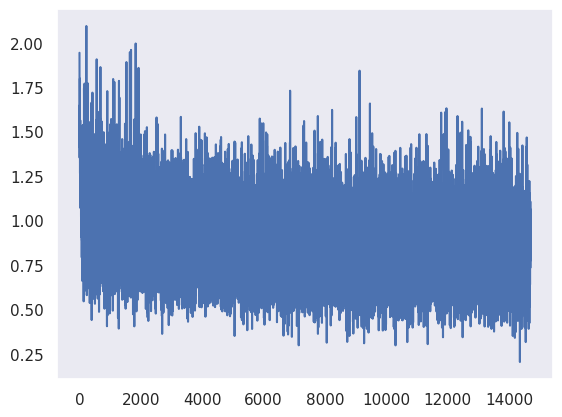

In [42]:
plt.plot(train_losses)

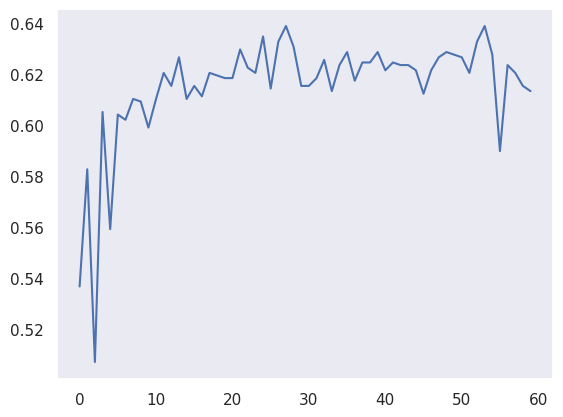

In [43]:
plt.plot(test_accuracy)

In [44]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 601/976 (0.6158)
{'acc_detail': tensor([0.5573, 0.7419, 0.6378, 0.5437], device='cuda:0'),
 'acc_unweighted': tensor(0.6202, device='cuda:0'),
 'acc_weighted': tensor(0.6158, device='cuda:0'),
 'f1s_detail': tensor([0.6795, 0.5669, 0.7074, 0.5362], device='cuda:0'),
 'f1s_unweighted': tensor(0.6225, device='cuda:0'),
 'f1s_weighted': tensor(0.6247, device='cuda:0'),
 'precision_detail': tensor([0.8704, 0.4587, 0.7941, 0.5290], device='cuda:0'),
 'recall_detail': tensor([0.5573, 0.7419, 0.6378, 0.5437], device='cuda:0'),
 'rocauc': tensor(0.8635, device='cuda:0'),
 'rocauc_detail': tensor([0.9218, 0.8393, 0.9210, 0.7718], device='cuda:0'),
 'uar': tensor(0.6202, device='cuda:0'),
 'wap': tensor(0.6708, device='cuda:0')}


tensor([[141,  22,   0,  90],
        [  0, 161,  31,  25],
        [  2,  83, 162,   7],
        [ 19,  85,  11, 137]], device='cuda:0')

In [45]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4/cremad_label4_m17_best_28epoch.pt
Correct: 626/976 (0.6414)
{'acc_detail': tensor([0.6957, 0.7005, 0.6969, 0.4802], device='cuda:0'),
 'acc_unweighted': tensor(0.6433, device='cuda:0'),
 'acc_weighted': tensor(0.6414, device='cuda:0'),
 'f1s_detail': tensor([0.7411, 0.5758, 0.7224, 0.5272], device='cuda:0'),
 'f1s_unweighted': tensor(0.6416, device='cuda:0'),
 'f1s_weighted': tensor(0.6443, device='cuda:0'),
 'precision_detail': tensor([0.7928, 0.4887, 0.7500, 0.5845], device='cuda:0'),
 'recall_detail': tensor([0.6957, 0.7005, 0.6969, 0.4802], device='cuda:0'),
 'rocauc': tensor(0.8634, device='cuda:0'),
 'rocauc_detail': tensor([0.9225, 0.8337, 0.9174, 0.7802], device='cuda:0'),
 'uar': tensor(0.6433, device='cuda:0'),
 'wap': tensor(0.6603, device='cuda:0')}


tensor([[176,  16,   1,  60],
        [  2, 152,  41,  22],
        [  4,  69, 177,   4],
        [ 40,  74,  17, 121]], device='cuda:0')

In [54]:
checkpoint_path = f'../models_cremad4/cremad4_m17_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [43]:
from IConNet.visualizer import display_module

In [ ]:
input_shape = (1,1,16000)
best_model.to(device)
input = torch.rand(input_shape).to(device)
display_module(
    model, input, 
    classes_to_visit={})

In [ ]:
display_module(
    best_model, input, 
    classes_to_visit={"FeBlocks", "FrontEndBlock"})

In [ ]:
display_module(
    best_model, input, 
    classes_to_visit={"FeBlocks", "FrontEndBlock", "Classifier"})

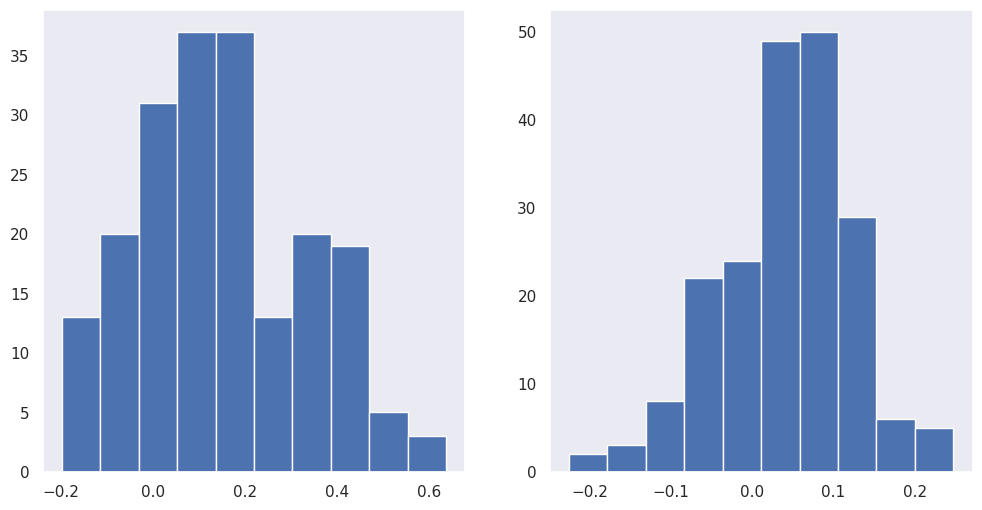

In [48]:
from IConNet.visualizer import visualize_model

layer = best_model.fe_blocks.blocks[0].block.layer

filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

Frequency domain: Filters' shapes vary by frequency bins


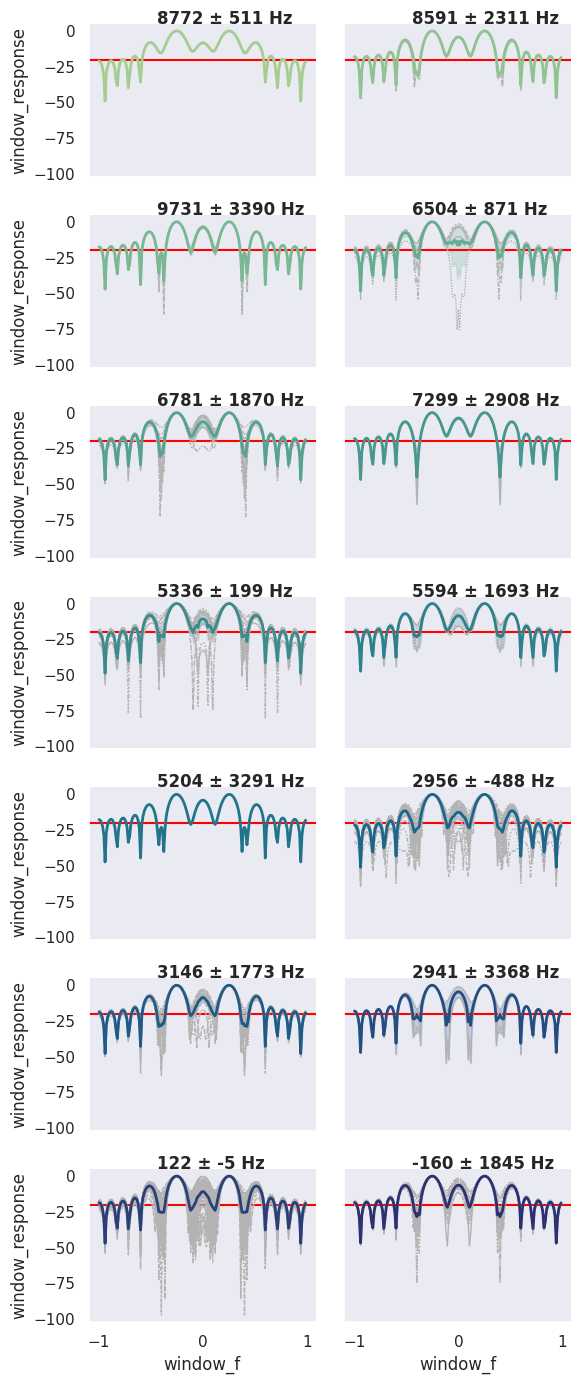

In [49]:
filtviz.visualize_filters(filter_domain='freq')

Time domain: Filters' shapes vary by frequency bins


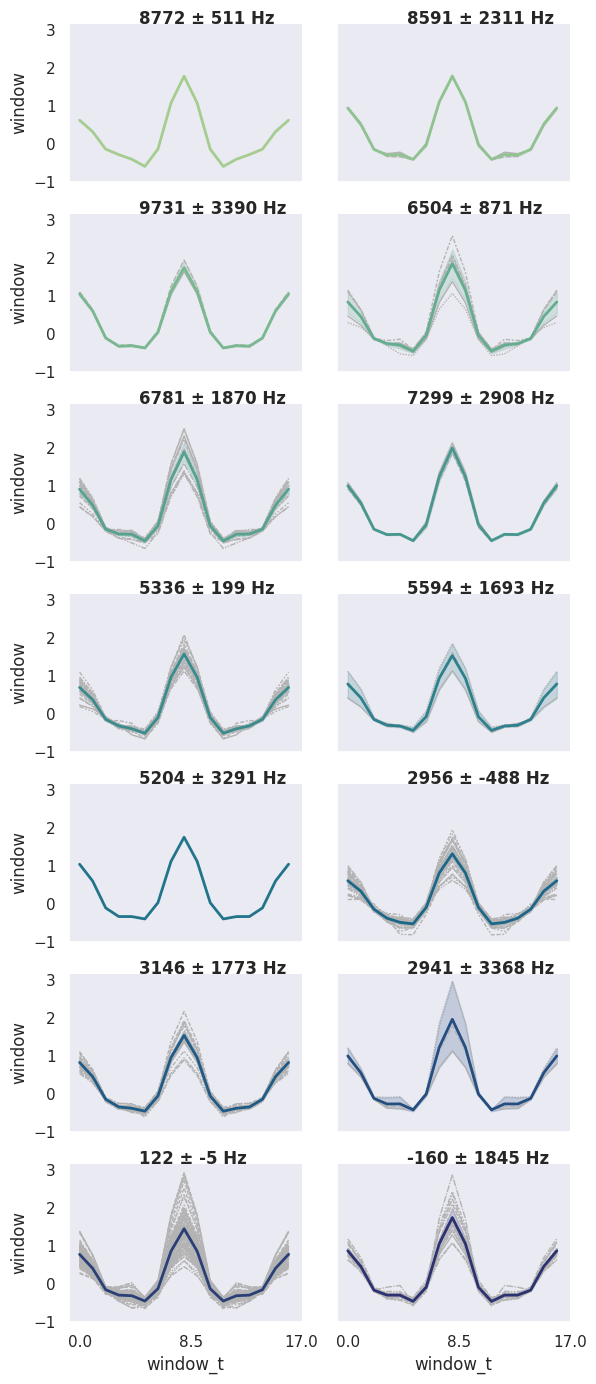

In [50]:
filtviz.visualize_filters(filter_domain='time')

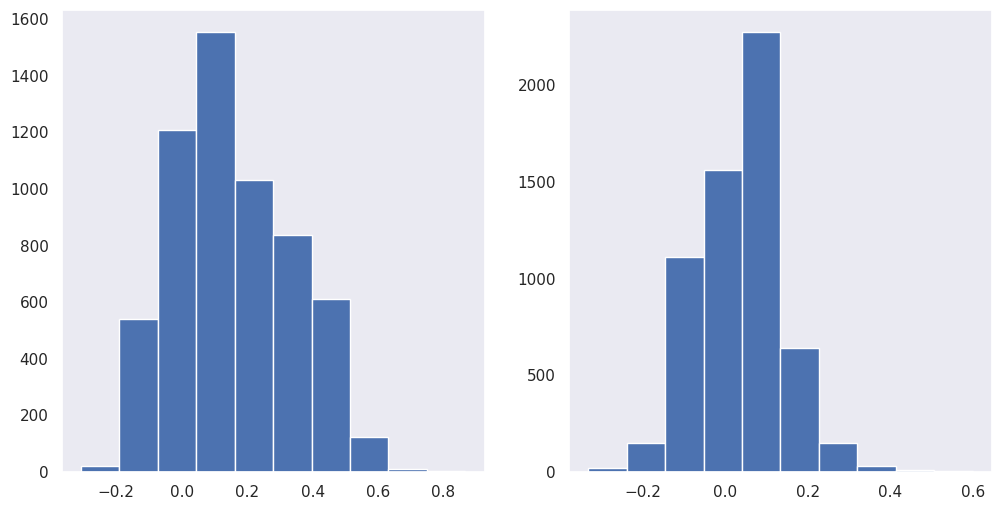

In [51]:
layer2 = best_model.fe_blocks.blocks[1].block.layer

filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = layer2.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz2.visualize_bands()

downsample_factor: 2 => new_sample_rate: 8000
Time domain: Filters' shapes vary by frequency bins


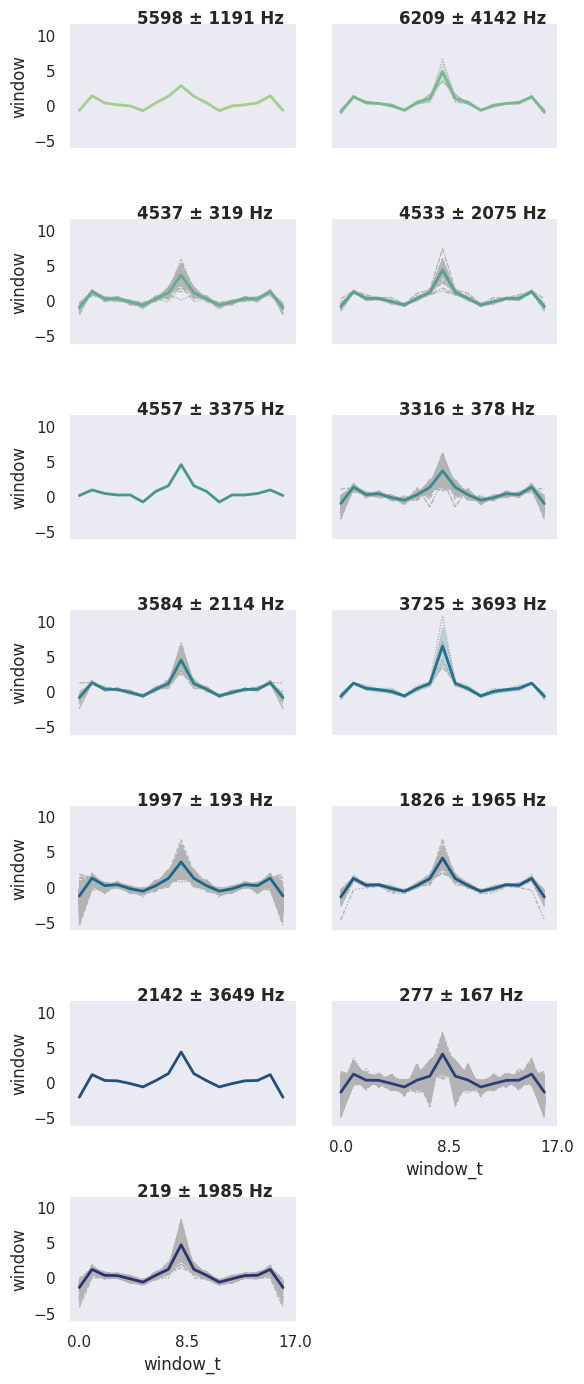

In [55]:
layer2 = best_model.fe_blocks.blocks[1].block.layer
downsample_factor = best_model.fe_blocks.blocks[0].stride
new_sample_rate = sr // downsample_factor
print(f'downsample_factor: {downsample_factor} => new_sample_rate: {new_sample_rate}')

filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = layer2.window_params, 
    window_length = 64,
    sample_rate = new_sample_rate
)
filtviz2.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


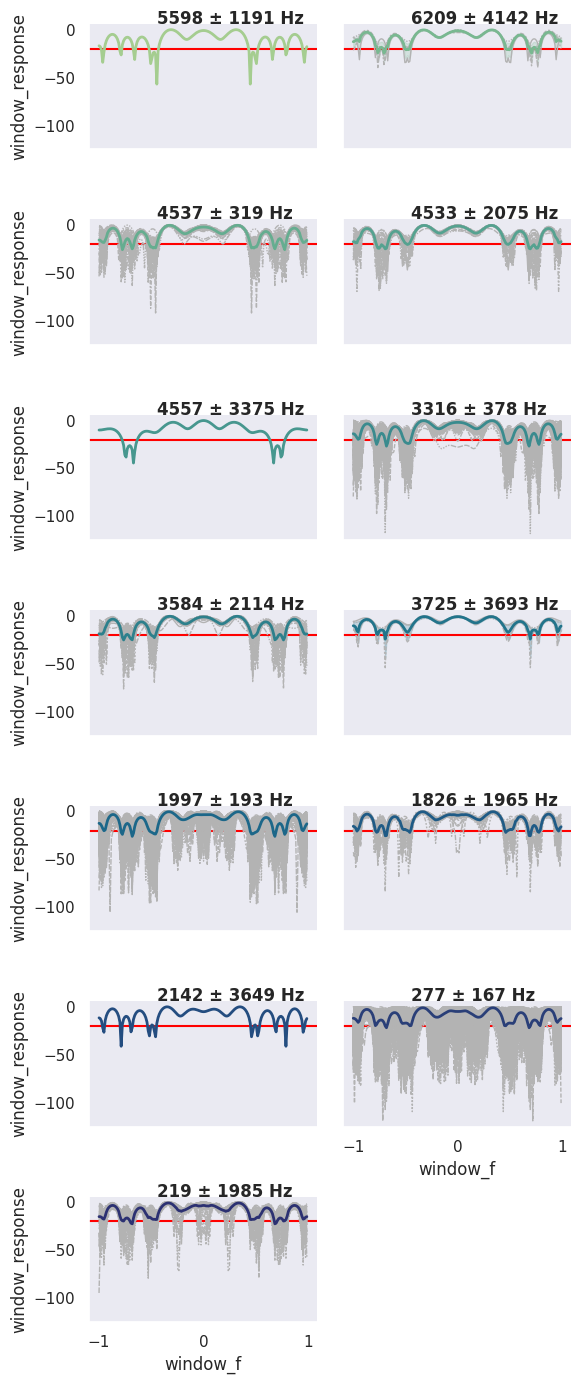

In [56]:
filtviz2.visualize_filters(filter_domain='freq')

In [57]:
del model
del best_model
gc.collect()

945